In [1]:
# fnames_behavioral = ['../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd', '../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd']
# fnames_cs_indices = ['../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50/channel_1.CS.csv', '../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv']

In [1]:
sess_indices = [4,5,48,49,56,58,59,60,61,64,66,69,70,74]


In [2]:
from fhd import *
import OpenEphys
import matplotlib.pyplot as plt
import numpy as np
from kaveh.toolbox import find_files_regex
import pandas as pd
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [3]:
import numpy as np
import csv

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
experiments_csv = '../data/tetrode-heptode-ephys_recording_notes - Sheet1.csv'

df = pd.read_csv(experiments_csv)
exp_info = df[['date','OE', 'EL', 'CH']].dropna()

sessions_info = []
behavioral_source_dir = '../data/behavioral/'
OE_source_dir = '../data/OpenEphys_data/'
fnames = []
for idx, (_, row) in enumerate(exp_info.iterrows()):
    print(idx)
    recording_date = row['date']
    sess_EL = row['EL']
    sess_OE = row['OE']
    chan = row['CH']
    OE_source = os.path.join(OE_source_dir, recording_date, recording_date + '_' + sess_OE)
    behavioral_file  = find_files_regex(os.path.join(behavioral_source_dir, recording_date.replace('-','_')), r".*{}\.fhd$".format(sess_EL.replace('-','')))
    curr_sess = (chan,)
    if len(behavioral_file) == 1:
        print(behavioral_file[0])
        curr_sess = (behavioral_file[0],) + curr_sess
    elif len(behavioral_file) > 1:
        raise ValueError('multiple behavioral files found for the same timestamp: {}'.format(behavioral_file))
    else:
        print('Behavioral file not found: {}'.format(sess_EL))
    if os.path.exists(OE_source):
        print(OE_source)
        curr_sess = (OE_source,) + curr_sess
    else:
        print('Open Ephys directory not found: {}'.format(OE_source))
    sessions_info = sessions_info + [curr_sess]
    print('-------------------')

0
../data/behavioral/2019_08_12/random_corrective_saccades_140142.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-01-39
-------------------
1
../data/behavioral/2019_08_12/random_corrective_saccades_142257.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-22-55
-------------------
2
../data/behavioral/2019_08_12/random_corrective_saccades_144317.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_14-43-14
-------------------
3
../data/behavioral/2019_08_12/random_corrective_saccades_150416.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-04-14
-------------------
4
../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54
-------------------
5
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-04-50
-------------------
6
../data/behavioral/2019_08_12/random_corrective_saccades_163652.fhd
../data/OpenEphys_data/2019-08-12/2019-08-12_16-36-49
------------

In [6]:
sessions_analyzed = [sessions_info[i] for i in sess_indices]

In [7]:
fnames_behavioral = [sa[1] for sa in sessions_analyzed]

In [8]:
fnames_cs_indices = [os.path.join(sa[0], 'channel_{}.CS.csv'.format(sa[2]-1)) for sa in sessions_analyzed]

In [18]:
def calc_saccade_reaction_time_to_target_offset(session, target_offset_indices_to_include):
    """
    Function for finding reaction times to targets
    """
    saccade_rt = []
    saccade_rt_target_offset_times = []
    saccade_rt_target_offset_indices = []
    
    for toff, i in zip(session.target_offset_times[target_offset_indices_to_include], target_offset_indices_to_include):
    
        delay_to_next_saccade = session.saccade_onset_times[np.argmax(session.saccade_onset_times > toff)] - toff
        delay_to_next_target_jump = session.target_onset_times[np.argmax(session.target_onset_times > toff)] - toff
        # Only consider reaction times that are less than 600ms and are occurring before the next target jump
        if delay_to_next_saccade <= delay_to_next_target_jump + 0.025 and delay_to_next_saccade <= 0.6 and delay_to_next_saccade>=0:
            saccade_rt.append(delay_to_next_saccade)
            saccade_rt_target_offset_times.append(toff)
            saccade_rt_target_offset_indices.append(i)

    saccade_rt = np.squeeze(np.array(saccade_rt))  # reaction times
    saccade_rt_target_offset_times = np.squeeze(np.array(saccade_rt_target_offset_times)) # target offset times for which the reaction times were calculated
    saccade_rt_target_offset_indices = np.squeeze(np.array(saccade_rt_target_offset_indices)) # indices of target offset times for which the reaction times were calculated
    
    return (saccade_rt, saccade_rt_target_offset_times, saccade_rt_target_offset_indices)

def bin_error_dirs(error_dirs):
    '''
    Bin error directions: Bins start from 157.5 and increaments counter-clockwise every 45 degrees => 8 bins, 0 to 7
    '''
    bins = np.arange(-180 + 22.5, 180, 45)
#     bins = np.arange(-180, 180, 45)
#     bins = np.arange(-180, 180, 60)
#     bins = [-180, -90, 0, 90]
#     bins = [-135, -45, 45, 135]
    bin_ind = np.digitize(error_dirs , bins, right=True)
    bin_ind[bin_ind == 8] = 0
#     bin_ind[bin_ind == 8] = 0
    return bin_ind


def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
#     cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [304]:
from scipy.io import loadmat
# saving mysess
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

prob_vect_all_for_file_son = {}
prob_vect_all_for_file_soff = {}
prob_vect_all_for_file_ton = {}
for i,fn in enumerate(fnames_behavioral):
    print(fn)
    input_fn_session = fn + '.session.pkl'
    with open(input_fn_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    
    with open(fnames_cs_indices[i], 'r') as csv_f:
        reader = csv.reader(csv_f)
        cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))
    cs_times = cs_indices/30000.0

    iss_range = 0.025
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []

    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    #     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
    #                                                              mysess.target_onset_times > son - iss_range), 
    #                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
    #                                                              mysess.target_offset_times > soff - iss_range)))[0])
        iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)
    cs_prob_bin_size = 0.05
    cs_prob_range = [-0.500, 00.500]
    avg_cs_range = 0.500
    prob_vect_all = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))

    for iss_son_time in mysess.saccade_offset_times[iss_saccades]:
        
        cs_t = cs_times[np.where(np.logical_and(cs_times < iss_son_time + avg_cs_range, cs_times > iss_son_time - avg_cs_range ))]
        prob_vect = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))
        prob_vect[np.digitize(cs_t, bins = np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size))] = 1
        prob_vect_all = prob_vect_all + prob_vect
        print(cs_t, '-----------------------', np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size))
    prob_vect_all = prob_vect_all/len(iss_saccades)
    prob_vect_all_for_file_soff[fn] = prob_vect_all

    
    prob_vect_all = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))

    for iss_son_time in mysess.saccade_onset_times[iss_saccades]:
        
        cs_t = cs_times[np.where(np.logical_and(cs_times < iss_son_time + avg_cs_range, cs_times > iss_son_time - avg_cs_range ))]
        prob_vect = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))
        prob_vect[np.digitize(cs_t, bins = np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size))] = 1
        prob_vect_all = prob_vect_all + prob_vect
        print(cs_t, '-----------------------', np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size))
    prob_vect_all = prob_vect_all/len(iss_saccades)
    prob_vect_all_for_file_son[fn] = prob_vect_all

    prob_vect_all = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))

    for iss_son_time in mysess.target_onset_times[non_iss_target_jumps]:
        
        cs_t = cs_times[np.where(np.logical_and(cs_times < iss_son_time + avg_cs_range, cs_times > iss_son_time - avg_cs_range ))]
        prob_vect = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))
        prob_vect[np.digitize(cs_t, bins = np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size))] = 1
        prob_vect_all = prob_vect_all + prob_vect
        print(cs_t, '-----------------------', np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size))
    prob_vect_all = prob_vect_all/len(iss_saccades)
    prob_vect_all_for_file_ton[fn] = prob_vect_all


../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
[4.8891     5.00273333 5.29663333] ----------------------- [4.738 4.788 4.838 4.888 4.938 4.988 5.038 5.088 5.138 5.188 5.238 5.288
 5.338 5.388 5.438 5.488 5.538 5.588 5.638]
[6.3535 6.6961] ----------------------- [6.144 6.194 6.244 6.294 6.344 6.394 6.444 6.494 6.544 6.594 6.644 6.694
 6.744 6.794 6.844 6.894 6.944 6.994 7.044]
[8.7311] ----------------------- [8.611 8.661 8.711 8.761 8.811 8.861 8.911 8.961 9.011 9.061 9.111 9.161
 9.211 9.261 9.311 9.361 9.411 9.461]
[] ----------------------- [9.143 9.193 9.243 9.293 9.343 9.393 9.443 9.493 9.543 9.593 9.643 9.693
 9.743 9.793 9.843 9.893 9.943 9.993]
[13.11966667 13.69646667] ----------------------- [13.126 13.176 13.226 13.276 13.326 13.376 13.426 13.476 13.526 13.576
 13.626 13.676 13.726 13.776 13.826 13.876 13.926 13.976]
[14.26026667 14.5394    ] ----------------------- [14.305 14.355 14.405 14.455 14.505 14.555 14.605 14.655 14.705 14.755
 14.805 14.855 14

[1296.29696667] ----------------------- [1295.74 1295.79 1295.84 1295.89 1295.94 1295.99 1296.04 1296.09 1296.14
 1296.19 1296.24 1296.29 1296.34 1296.39 1296.44 1296.49 1296.54 1296.59
 1296.64]
[] ----------------------- [1303.856 1303.906 1303.956 1304.006 1304.056 1304.106 1304.156 1304.206
 1304.256 1304.306 1304.356 1304.406 1304.456 1304.506 1304.556 1304.606
 1304.656 1304.706 1304.756]
[1307.8971     1308.27463333 1308.4241    ] ----------------------- [1307.762 1307.812 1307.862 1307.912 1307.962 1308.012 1308.062 1308.112
 1308.162 1308.212 1308.262 1308.312 1308.362 1308.412 1308.462 1308.512
 1308.562 1308.612 1308.662]
[1309.4947] ----------------------- [1309.309 1309.359 1309.409 1309.459 1309.509 1309.559 1309.609 1309.659
 1309.709 1309.759 1309.809 1309.859 1309.909 1309.959 1310.009 1310.059
 1310.109 1310.159 1310.209]
[] ----------------------- [1310.43 1310.48 1310.53 1310.58 1310.63 1310.68 1310.73 1310.78 1310.83
 1310.88 1310.93 1310.98 1311.03 1311.08 1311.13

[] ----------------------- [1079.007 1079.057 1079.107 1079.157 1079.207 1079.257 1079.307 1079.357
 1079.407 1079.457 1079.507 1079.557 1079.607 1079.657 1079.707 1079.757
 1079.807 1079.857 1079.907]
[1085.388      1085.47223333] ----------------------- [1085.092 1085.142 1085.192 1085.242 1085.292 1085.342 1085.392 1085.442
 1085.492 1085.542 1085.592 1085.642 1085.692 1085.742 1085.792 1085.842
 1085.892 1085.942 1085.992]
[] ----------------------- [1086.198 1086.248 1086.298 1086.348 1086.398 1086.448 1086.498 1086.548
 1086.598 1086.648 1086.698 1086.748 1086.798 1086.848 1086.898 1086.948
 1086.998 1087.048 1087.098]
[1087.59213333 1088.0924    ] ----------------------- [1087.639 1087.689 1087.739 1087.789 1087.839 1087.889 1087.939 1087.989
 1088.039 1088.089 1088.139 1088.189 1088.239 1088.289 1088.339 1088.389
 1088.439 1088.489 1088.539]
[1089.07683333 1089.20616667] ----------------------- [1088.754 1088.804 1088.854 1088.904 1088.954 1089.004 1089.054 1089.104
 1089.154 1

 237.207 237.257 237.307 237.357 237.407 237.457 237.507 237.557 237.607]
[238.08256667] ----------------------- [237.96 238.01 238.06 238.11 238.16 238.21 238.26 238.31 238.36 238.41
 238.46 238.51 238.56 238.61 238.66 238.71 238.76 238.81]
[239.6208] ----------------------- [239.018 239.068 239.118 239.168 239.218 239.268 239.318 239.368 239.418
 239.468 239.518 239.568 239.618 239.668 239.718 239.768 239.818 239.868]
[240.2736     240.38903333] ----------------------- [239.762 239.812 239.862 239.912 239.962 240.012 240.062 240.112 240.162
 240.212 240.262 240.312 240.362 240.412 240.462 240.512 240.562 240.612]
[] ----------------------- [240.488 240.538 240.588 240.638 240.688 240.738 240.788 240.838 240.888
 240.938 240.988 241.038 241.088 241.138 241.188 241.238 241.288 241.338]
[] ----------------------- [241.573 241.623 241.673 241.723 241.773 241.823 241.873 241.923 241.973
 242.023 242.073 242.123 242.173 242.223 242.273 242.323 242.373 242.423]
[242.54236667] --------------

[792.49363333] ----------------------- [791.986 792.036 792.086 792.136 792.186 792.236 792.286 792.336 792.386
 792.436 792.486 792.536 792.586 792.636 792.686 792.736 792.786 792.836
 792.886]
[] ----------------------- [792.795 792.845 792.895 792.945 792.995 793.045 793.095 793.145 793.195
 793.245 793.295 793.345 793.395 793.445 793.495 793.545 793.595 793.645
 793.695]
[798.4642] ----------------------- [798.217 798.267 798.317 798.367 798.417 798.467 798.517 798.567 798.617
 798.667 798.717 798.767 798.817 798.867 798.917 798.967 799.017 799.067
 799.117]
[799.815] ----------------------- [799.021 799.071 799.121 799.171 799.221 799.271 799.321 799.371 799.421
 799.471 799.521 799.571 799.621 799.671 799.721 799.771 799.821 799.871
 799.921]
[804.6021] ----------------------- [803.833 803.883 803.933 803.983 804.033 804.083 804.133 804.183 804.233
 804.283 804.333 804.383 804.433 804.483 804.533 804.583 804.633 804.683
 804.733]
[804.6021     804.94693333] ----------------------

[1378.68223333 1379.04736667] ----------------------- [1378.248 1378.298 1378.348 1378.398 1378.448 1378.498 1378.548 1378.598
 1378.648 1378.698 1378.748 1378.798 1378.848 1378.898 1378.948 1378.998
 1379.048 1379.098 1379.148]
[1379.04736667] ----------------------- [1378.971 1379.021 1379.071 1379.121 1379.171 1379.221 1379.271 1379.321
 1379.371 1379.421 1379.471 1379.521 1379.571 1379.621 1379.671 1379.721
 1379.771 1379.821 1379.871]
[1380.41826667] ----------------------- [1379.485 1379.535 1379.585 1379.635 1379.685 1379.735 1379.785 1379.835
 1379.885 1379.935 1379.985 1380.035 1380.085 1380.135 1380.185 1380.235
 1380.285 1380.335 1380.385]
[1380.41826667 1380.80743333] ----------------------- [1380.231 1380.281 1380.331 1380.381 1380.431 1380.481 1380.531 1380.581
 1380.631 1380.681 1380.731 1380.781 1380.831 1380.881 1380.931 1380.981
 1381.031 1381.081 1381.131]
[1380.80743333] ----------------------- [1380.634 1380.684 1380.734 1380.784 1380.834 1380.884 1380.934 1380.984

[5.92853333 6.4546     6.62796667] ----------------------- [5.941 5.991 6.041 6.091 6.141 6.191 6.241 6.291 6.341 6.391 6.441 6.491
 6.541 6.591 6.641 6.691 6.741 6.791 6.841]
[12.78446667] ----------------------- [12.319 12.369 12.419 12.469 12.519 12.569 12.619 12.669 12.719 12.769
 12.819 12.869 12.919 12.969 13.019 13.069 13.119 13.169]
[] ----------------------- [22.932 22.982 23.032 23.082 23.132 23.182 23.232 23.282 23.332 23.382
 23.432 23.482 23.532 23.582 23.632 23.682 23.732 23.782]
[26.5676] ----------------------- [26.312 26.362 26.412 26.462 26.512 26.562 26.612 26.662 26.712 26.762
 26.812 26.862 26.912 26.962 27.012 27.062 27.112 27.162]
[] ----------------------- [52.463 52.513 52.563 52.613 52.663 52.713 52.763 52.813 52.863 52.913
 52.963 53.013 53.063 53.113 53.163 53.213 53.263 53.313 53.363]
[54.22583333] ----------------------- [53.977 54.027 54.077 54.127 54.177 54.227 54.277 54.327 54.377 54.427
 54.477 54.527 54.577 54.627 54.677 54.727 54.777 54.827 54.877]
[

[143.63316667] ----------------------- [143.001 143.051 143.101 143.151 143.201 143.251 143.301 143.351 143.401
 143.451 143.501 143.551 143.601 143.651 143.701 143.751 143.801 143.851]
[145.00906667] ----------------------- [144.108 144.158 144.208 144.258 144.308 144.358 144.408 144.458 144.508
 144.558 144.608 144.658 144.708 144.758 144.808 144.858 144.908 144.958]
[] ----------------------- [161.738 161.788 161.838 161.888 161.938 161.988 162.038 162.088 162.138
 162.188 162.238 162.288 162.338 162.388 162.438 162.488 162.538 162.588]
[163.88876667] ----------------------- [162.944 162.994 163.044 163.094 163.144 163.194 163.244 163.294 163.344
 163.394 163.444 163.494 163.544 163.594 163.644 163.694 163.744 163.794]
[164.1743] ----------------------- [164.121 164.171 164.221 164.271 164.321 164.371 164.421 164.471 164.521
 164.571 164.621 164.671 164.721 164.771 164.821 164.871 164.921 164.971]
[] ----------------------- [167.316 167.366 167.416 167.466 167.516 167.566 167.616 16

[91.21003333] ----------------------- [91.08 91.13 91.18 91.23 91.28 91.33 91.38 91.43 91.48 91.53 91.58 91.63
 91.68 91.73 91.78 91.83 91.88 91.93 91.98]
[] ----------------------- [92.1  92.15 92.2  92.25 92.3  92.35 92.4  92.45 92.5  92.55 92.6  92.65
 92.7  92.75 92.8  92.85 92.9  92.95 93.  ]
[] ----------------------- [92.508 92.558 92.608 92.658 92.708 92.758 92.808 92.858 92.908 92.958
 93.008 93.058 93.108 93.158 93.208 93.258 93.308 93.358 93.408]
[93.54636667] ----------------------- [92.759 92.809 92.859 92.909 92.959 93.009 93.059 93.109 93.159 93.209
 93.259 93.309 93.359 93.409 93.459 93.509 93.559 93.609 93.659]
[93.54636667 93.9548    ] ----------------------- [93.197 93.247 93.297 93.347 93.397 93.447 93.497 93.547 93.597 93.647
 93.697 93.747 93.797 93.847 93.897 93.947 93.997 94.047 94.097]
[107.24613333] ----------------------- [107.086 107.136 107.186 107.236 107.286 107.336 107.386 107.436 107.486
 107.536 107.586 107.636 107.686 107.736 107.786 107.836 107.886 1

[764.87953333] ----------------------- [764.442 764.492 764.542 764.592 764.642 764.692 764.742 764.792 764.842
 764.892 764.942 764.992 765.042 765.092 765.142 765.192 765.242 765.292
 765.342]
[] ----------------------- [765.004 765.054 765.104 765.154 765.204 765.254 765.304 765.354 765.404
 765.454 765.504 765.554 765.604 765.654 765.704 765.754 765.804 765.854
 765.904]
[] ----------------------- [765.774 765.824 765.874 765.924 765.974 766.024 766.074 766.124 766.174
 766.224 766.274 766.324 766.374 766.424 766.474 766.524 766.574 766.624
 766.674]
[767.9813] ----------------------- [767.228 767.278 767.328 767.378 767.428 767.478 767.528 767.578 767.628
 767.678 767.728 767.778 767.828 767.878 767.928 767.978 768.028 768.078
 768.128]
[767.9813     768.41956667] ----------------------- [767.99 768.04 768.09 768.14 768.19 768.24 768.29 768.34 768.39 768.44
 768.49 768.54 768.59 768.64 768.69 768.74 768.79 768.84 768.89]
[768.41956667 769.2583    ] ----------------------- [768.397

[1399.1589] ----------------------- [1398.841 1398.891 1398.941 1398.991 1399.041 1399.091 1399.141 1399.191
 1399.241 1399.291 1399.341 1399.391 1399.441 1399.491 1399.541 1399.591
 1399.641 1399.691 1399.741]
[1399.98656667 1400.5737    ] ----------------------- [1399.851 1399.901 1399.951 1400.001 1400.051 1400.101 1400.151 1400.201
 1400.251 1400.301 1400.351 1400.401 1400.451 1400.501 1400.551 1400.601
 1400.651 1400.701 1400.751]
[1400.5737] ----------------------- [1400.411 1400.461 1400.511 1400.561 1400.611 1400.661 1400.711 1400.761
 1400.811 1400.861 1400.911 1400.961 1401.011 1401.061 1401.111 1401.161
 1401.211 1401.261 1401.311]
[1403.28186667] ----------------------- [1403.014 1403.064 1403.114 1403.164 1403.214 1403.264 1403.314 1403.364
 1403.414 1403.464 1403.514 1403.564 1403.614 1403.664 1403.714 1403.764
 1403.814 1403.864 1403.914]
[] ----------------------- [1404.004 1404.054 1404.104 1404.154 1404.204 1404.254 1404.304 1404.354
 1404.404 1404.454 1404.504 1404.5

[127.257] ----------------------- [126.644 126.694 126.744 126.794 126.844 126.894 126.944 126.994 127.044
 127.094 127.144 127.194 127.244 127.294 127.344 127.394 127.444 127.494
 127.544]
[175.74196667] ----------------------- [175.255 175.305 175.355 175.405 175.455 175.505 175.555 175.605 175.655
 175.705 175.755 175.805 175.855 175.905 175.955 176.005 176.055 176.105]
[] ----------------------- [176.514 176.564 176.614 176.664 176.714 176.764 176.814 176.864 176.914
 176.964 177.014 177.064 177.114 177.164 177.214 177.264 177.314 177.364]
[] ----------------------- [212.374 212.424 212.474 212.524 212.574 212.624 212.674 212.724 212.774
 212.824 212.874 212.924 212.974 213.024 213.074 213.124 213.174 213.224]
[213.95736667] ----------------------- [213.98 214.03 214.08 214.13 214.18 214.23 214.28 214.33 214.38 214.43
 214.48 214.53 214.58 214.63 214.68 214.73 214.78 214.83]
[] ----------------------- [214.722 214.772 214.822 214.872 214.922 214.972 215.022 215.072 215.122
 215.172

[16.9284] ----------------------- [16.582 16.632 16.682 16.732 16.782 16.832 16.882 16.932 16.982 17.032
 17.082 17.132 17.182 17.232 17.282 17.332 17.382 17.432]
[] ----------------------- [17.445 17.495 17.545 17.595 17.645 17.695 17.745 17.795 17.845 17.895
 17.945 17.995 18.045 18.095 18.145 18.195 18.245 18.295]
[18.54093333] ----------------------- [17.853 17.903 17.953 18.003 18.053 18.103 18.153 18.203 18.253 18.303
 18.353 18.403 18.453 18.503 18.553 18.603 18.653 18.703]
[19.51956667] ----------------------- [19.016 19.066 19.116 19.166 19.216 19.266 19.316 19.366 19.416 19.466
 19.516 19.566 19.616 19.666 19.716 19.766 19.816 19.866]
[19.51956667 20.1494    ] ----------------------- [19.425 19.475 19.525 19.575 19.625 19.675 19.725 19.775 19.825 19.875
 19.925 19.975 20.025 20.075 20.125 20.175 20.225 20.275]
[20.1494] ----------------------- [20.036 20.086 20.136 20.186 20.236 20.286 20.336 20.386 20.436 20.486
 20.536 20.586 20.636 20.686 20.736 20.786 20.836 20.886]
[] --

[] ----------------------- [592.297 592.347 592.397 592.447 592.497 592.547 592.597 592.647 592.697
 592.747 592.797 592.847 592.897 592.947 592.997 593.047 593.097 593.147
 593.197]
[593.25156667 593.44326667 593.92083333] ----------------------- [593.021 593.071 593.121 593.171 593.221 593.271 593.321 593.371 593.421
 593.471 593.521 593.571 593.621 593.671 593.721 593.771 593.821 593.871
 593.921]
[593.92083333 594.10323333 594.48326667] ----------------------- [593.808 593.858 593.908 593.958 594.008 594.058 594.108 594.158 594.208
 594.258 594.308 594.358 594.408 594.458 594.508 594.558 594.608 594.658
 594.708]
[594.48326667 594.91086667] ----------------------- [594.225 594.275 594.325 594.375 594.425 594.475 594.525 594.575 594.625
 594.675 594.725 594.775 594.825 594.875 594.925 594.975 595.025 595.075
 595.125]
[594.91086667] ----------------------- [594.949 594.999 595.049 595.099 595.149 595.199 595.249 595.299 595.349
 595.399 595.449 595.499 595.549 595.599 595.649 595.69

[789.228] ----------------------- [788.682 788.732 788.782 788.832 788.882 788.932 788.982 789.032 789.082
 789.132 789.182 789.232 789.282 789.332 789.382 789.432 789.482 789.532
 789.582]
[790.54796667] ----------------------- [790.494 790.544 790.594 790.644 790.694 790.744 790.794 790.844 790.894
 790.944 790.994 791.044 791.094 791.144 791.194 791.244 791.294 791.344
 791.394]
[] ----------------------- [800.58 800.63 800.68 800.73 800.78 800.83 800.88 800.93 800.98 801.03
 801.08 801.13 801.18 801.23 801.28 801.33 801.38 801.43 801.48]
[] ----------------------- [803.217 803.267 803.317 803.367 803.417 803.467 803.517 803.567 803.617
 803.667 803.717 803.767 803.817 803.867 803.917 803.967 804.017 804.067
 804.117]
[67.37163333] ----------------------- [66.469 66.519 66.569 66.619 66.669 66.719 66.769 66.819 66.869 66.919
 66.969 67.019 67.069 67.119 67.169 67.219 67.269 67.319 67.369]
[] ----------------------- [67.951 68.001 68.051 68.101 68.151 68.201 68.251 68.301 68.351 68.4

 261.133 261.183 261.233 261.283 261.333 261.383 261.433 261.483 261.533]
[] ----------------------- [261.091 261.141 261.191 261.241 261.291 261.341 261.391 261.441 261.491
 261.541 261.591 261.641 261.691 261.741 261.791 261.841 261.891 261.941]
[] ----------------------- [262.105 262.155 262.205 262.255 262.305 262.355 262.405 262.455 262.505
 262.555 262.605 262.655 262.705 262.755 262.805 262.855 262.905 262.955]
[] ----------------------- [262.555 262.605 262.655 262.705 262.755 262.805 262.855 262.905 262.955
 263.005 263.055 263.105 263.155 263.205 263.255 263.305 263.355 263.405]
[] ----------------------- [263.081 263.131 263.181 263.231 263.281 263.331 263.381 263.431 263.481
 263.531 263.581 263.631 263.681 263.731 263.781 263.831 263.881 263.931]
[264.98793333 265.1513    ] ----------------------- [264.943 264.993 265.043 265.093 265.143 265.193 265.243 265.293 265.343
 265.393 265.443 265.493 265.543 265.593 265.643 265.693 265.743 265.793]
[] ----------------------- [266

[790.54796667] ----------------------- [790.296 790.346 790.396 790.446 790.496 790.546 790.596 790.646 790.696
 790.746 790.796 790.846 790.896 790.946 790.996 791.046 791.096 791.146
 791.196]
[792.8414] ----------------------- [792.5  792.55 792.6  792.65 792.7  792.75 792.8  792.85 792.9  792.95
 793.   793.05 793.1  793.15 793.2  793.25 793.3  793.35 793.4 ]
[] ----------------------- [800.361 800.411 800.461 800.511 800.561 800.611 800.661 800.711 800.761
 800.811 800.861 800.911 800.961 801.011 801.061 801.111 801.161 801.211
 801.261]
[] ----------------------- [802.659 802.709 802.759 802.809 802.859 802.909 802.959 803.009 803.059
 803.109 803.159 803.209 803.259 803.309 803.359 803.409 803.459 803.509
 803.559]
[] ----------------------- [803.064 803.114 803.164 803.214 803.264 803.314 803.364 803.414 803.464
 803.514 803.564 803.614 803.664 803.714 803.764 803.814 803.864 803.914
 803.964]
[] ----------------------- [803.765 803.815 803.865 803.915 803.965 804.015 804.065 8

[] ----------------------- [847.308 847.358 847.408 847.458 847.508 847.558 847.608 847.658 847.708
 847.758 847.808 847.858 847.908 847.958 848.008 848.058 848.108 848.158
 848.208]
[850.25743333 850.33786667 850.5037    ] ----------------------- [849.569 849.619 849.669 849.719 849.769 849.819 849.869 849.919 849.969
 850.019 850.069 850.119 850.169 850.219 850.269 850.319 850.369 850.419
 850.469]
[851.4272] ----------------------- [850.662 850.712 850.762 850.812 850.862 850.912 850.962 851.012 851.062
 851.112 851.162 851.212 851.262 851.312 851.362 851.412 851.462 851.512
 851.562]
[] ----------------------- [852.03 852.08 852.13 852.18 852.23 852.28 852.33 852.38 852.43 852.48
 852.53 852.58 852.63 852.68 852.73 852.78 852.83 852.88 852.93]
[] ----------------------- [862.184 862.234 862.284 862.334 862.384 862.434 862.484 862.534 862.584
 862.634 862.684 862.734 862.784 862.834 862.884 862.934 862.984 863.034
 863.084]
[863.8948 864.0439] ----------------------- [863.304 863.35

[] ----------------------- [329.312 329.362 329.412 329.462 329.512 329.562 329.612 329.662 329.712
 329.762 329.812 329.862 329.912 329.962 330.012 330.062 330.112 330.162]
[330.67403333 330.77433333 330.92023333] ----------------------- [330.52 330.57 330.62 330.67 330.72 330.77 330.82 330.87 330.92 330.97
 331.02 331.07 331.12 331.17 331.22 331.27 331.32 331.37]
[332.0267] ----------------------- [331.67 331.72 331.77 331.82 331.87 331.92 331.97 332.02 332.07 332.12
 332.17 332.22 332.27 332.32 332.37 332.42 332.47 332.52]
[333.1846] ----------------------- [333.026 333.076 333.126 333.176 333.226 333.276 333.326 333.376 333.426
 333.476 333.526 333.576 333.626 333.676 333.726 333.776 333.826 333.876]
[] ----------------------- [334.345 334.395 334.445 334.495 334.545 334.595 334.645 334.695 334.745
 334.795 334.845 334.895 334.945 334.995 335.045 335.095 335.145 335.195]
[] ----------------------- [335.548 335.598 335.648 335.698 335.748 335.798 335.848 335.898 335.948
 335.998 336

[] ----------------------- [1515.325 1515.375 1515.425 1515.475 1515.525 1515.575 1515.625 1515.675
 1515.725 1515.775 1515.825 1515.875 1515.925 1515.975 1516.025 1516.075
 1516.125 1516.175 1516.225]
[1517.2575] ----------------------- [1516.544 1516.594 1516.644 1516.694 1516.744 1516.794 1516.844 1516.894
 1516.944 1516.994 1517.044 1517.094 1517.144 1517.194 1517.244 1517.294
 1517.344 1517.394 1517.444]
[] ----------------------- [1528.216 1528.266 1528.316 1528.366 1528.416 1528.466 1528.516 1528.566
 1528.616 1528.666 1528.716 1528.766 1528.816 1528.866 1528.916 1528.966
 1529.016 1529.066 1529.116]
[1530.41613333] ----------------------- [1529.547 1529.597 1529.647 1529.697 1529.747 1529.797 1529.847 1529.897
 1529.947 1529.997 1530.047 1530.097 1530.147 1530.197 1530.247 1530.297
 1530.347 1530.397 1530.447]
[1530.41613333] ----------------------- [1530.324 1530.374 1530.424 1530.474 1530.524 1530.574 1530.624 1530.674
 1530.724 1530.774 1530.824 1530.874 1530.924 1530.974 15

[410.69773333] ----------------------- [409.758 409.808 409.858 409.908 409.958 410.008 410.058 410.108 410.158
 410.208 410.258 410.308 410.358 410.408 410.458 410.508 410.558 410.608]
[410.69773333] ----------------------- [410.482 410.532 410.582 410.632 410.682 410.732 410.782 410.832 410.882
 410.932 410.982 411.032 411.082 411.132 411.182 411.232 411.282 411.332]
[] ----------------------- [410.886 410.936 410.986 411.036 411.086 411.136 411.186 411.236 411.286
 411.336 411.386 411.436 411.486 411.536 411.586 411.636 411.686 411.736]
[] ----------------------- [412.101 412.151 412.201 412.251 412.301 412.351 412.401 412.451 412.501
 412.551 412.601 412.651 412.701 412.751 412.801 412.851 412.901 412.951]
[] ----------------------- [412.502 412.552 412.602 412.652 412.702 412.752 412.802 412.852 412.902
 412.952 413.002 413.052 413.102 413.152 413.202 413.252 413.302 413.352]
[413.79713333] ----------------------- [413.231 413.281 413.331 413.381 413.431 413.481 413.531 413.581 41

[932.1769] ----------------------- [931.778 931.828 931.878 931.928 931.978 932.028 932.078 932.128 932.178
 932.228 932.278 932.328 932.378 932.428 932.478 932.528 932.578 932.628
 932.678]
[] ----------------------- [932.696 932.746 932.796 932.846 932.896 932.946 932.996 933.046 933.096
 933.146 933.196 933.246 933.296 933.346 933.396 933.446 933.496 933.546
 933.596]
[933.8941] ----------------------- [933.528 933.578 933.628 933.678 933.728 933.778 933.828 933.878 933.928
 933.978 934.028 934.078 934.128 934.178 934.228 934.278 934.328 934.378
 934.428]
[] ----------------------- [934.084 934.134 934.184 934.234 934.284 934.334 934.384 934.434 934.484
 934.534 934.584 934.634 934.684 934.734 934.784 934.834 934.884 934.934
 934.984]
[] ----------------------- [934.958 935.008 935.058 935.108 935.158 935.208 935.258 935.308 935.358
 935.408 935.458 935.508 935.558 935.608 935.658 935.708 935.758 935.808
 935.858]
[] ----------------------- [935.712 935.762 935.812 935.862 935.912 9

[1357.90253333 1358.7439    ] ----------------------- [1357.946 1357.996 1358.046 1358.096 1358.146 1358.196 1358.246 1358.296
 1358.346 1358.396 1358.446 1358.496 1358.546 1358.596 1358.646 1358.696
 1358.746 1358.796 1358.846]
[1358.7439] ----------------------- [1358.431 1358.481 1358.531 1358.581 1358.631 1358.681 1358.731 1358.781
 1358.831 1358.881 1358.931 1358.981 1359.031 1359.081 1359.131 1359.181
 1359.231 1359.281 1359.331]
[] ----------------------- [1359.165 1359.215 1359.265 1359.315 1359.365 1359.415 1359.465 1359.515
 1359.565 1359.615 1359.665 1359.715 1359.765 1359.815 1359.865 1359.915
 1359.965 1360.015 1360.065]
[1360.22283333] ----------------------- [1359.573 1359.623 1359.673 1359.723 1359.773 1359.823 1359.873 1359.923
 1359.973 1360.023 1360.073 1360.123 1360.173 1360.223 1360.273 1360.323
 1360.373 1360.423 1360.473]
[1360.22283333 1360.94503333] ----------------------- [1360.185 1360.235 1360.285 1360.335 1360.385 1360.435 1360.485 1360.535
 1360.585 1360.6

[4.1458] ----------------------- [3.454 3.504 3.554 3.604 3.654 3.704 3.754 3.804 3.854 3.904 3.954 4.004
 4.054 4.104 4.154 4.204 4.254 4.304 4.354]
[] ----------------------- [4.667 4.717 4.767 4.817 4.867 4.917 4.967 5.017 5.067 5.117 5.167 5.217
 5.267 5.317 5.367 5.417 5.467 5.517 5.567]
[6.1505 6.2431] ----------------------- [5.953 6.003 6.053 6.103 6.153 6.203 6.253 6.303 6.353 6.403 6.453 6.503
 6.553 6.603 6.653 6.703 6.753 6.803 6.853]
[7.29693333] ----------------------- [7.296 7.346 7.396 7.446 7.496 7.546 7.596 7.646 7.696 7.746 7.796 7.846
 7.896 7.946 7.996 8.046 8.096 8.146]
[] ----------------------- [8.494 8.544 8.594 8.644 8.694 8.744 8.794 8.844 8.894 8.944 8.994 9.044
 9.094 9.144 9.194 9.244 9.294 9.344]
[] ----------------------- [ 9.814  9.864  9.914  9.964 10.014 10.064 10.114 10.164 10.214 10.264
 10.314 10.364 10.414 10.464 10.514 10.564 10.614 10.664]
[11.46743333 11.88896667] ----------------------- [11.272 11.322 11.372 11.422 11.472 11.522 11.572 11.622 

[] ----------------------- [8.474 8.524 8.574 8.624 8.674 8.724 8.774 8.824 8.874 8.924 8.974 9.024
 9.074 9.124 9.174 9.224 9.274 9.324]
[] ----------------------- [ 9.792  9.842  9.892  9.942  9.992 10.042 10.092 10.142 10.192 10.242
 10.292 10.342 10.392 10.442 10.492 10.542 10.592 10.642]
[11.46743333 11.88896667] ----------------------- [11.249 11.299 11.349 11.399 11.449 11.499 11.549 11.599 11.649 11.699
 11.749 11.799 11.849 11.899 11.949 11.999 12.049 12.099]
[13.30526667] ----------------------- [12.379 12.429 12.479 12.529 12.579 12.629 12.679 12.729 12.779 12.829
 12.879 12.929 12.979 13.029 13.079 13.129 13.179 13.229]
[25.86856667] ----------------------- [25.466 25.516 25.566 25.616 25.666 25.716 25.766 25.816 25.866 25.916
 25.966 26.016 26.066 26.116 26.166 26.216 26.266 26.316]
[26.9317     27.19636667] ----------------------- [26.725 26.775 26.825 26.875 26.925 26.975 27.025 27.075 27.125 27.175
 27.225 27.275 27.325 27.375 27.425 27.475 27.525 27.575]
[] -----------

 1166.379 1166.429 1166.479]
[1167.26       1167.5252     1167.85083333] ----------------------- [1167.024 1167.074 1167.124 1167.174 1167.224 1167.274 1167.324 1167.374
 1167.424 1167.474 1167.524 1167.574 1167.624 1167.674 1167.724 1167.774
 1167.824 1167.874 1167.924]
[] ----------------------- [1168.307 1168.357 1168.407 1168.457 1168.507 1168.557 1168.607 1168.657
 1168.707 1168.757 1168.807 1168.857 1168.907 1168.957 1169.007 1169.057
 1169.107 1169.157 1169.207]
[] ----------------------- [1175.582 1175.632 1175.682 1175.732 1175.782 1175.832 1175.882 1175.932
 1175.982 1176.032 1176.082 1176.132 1176.182 1176.232 1176.282 1176.332
 1176.382 1176.432 1176.482]
[1184.41166667] ----------------------- [1183.505 1183.555 1183.605 1183.655 1183.705 1183.755 1183.805 1183.855
 1183.905 1183.955 1184.005 1184.055 1184.105 1184.155 1184.205 1184.255
 1184.305 1184.355 1184.405]
[] ----------------------- [1185.896 1185.946 1185.996 1186.046 1186.096 1186.146 1186.196 1186.246
 1186.296

[370.30736667] ----------------------- [369.546 369.596 369.646 369.696 369.746 369.796 369.846 369.896 369.946
 369.996 370.046 370.096 370.146 370.196 370.246 370.296 370.346 370.396]
[370.30736667 370.62786667] ----------------------- [369.996 370.046 370.096 370.146 370.196 370.246 370.296 370.346 370.396
 370.446 370.496 370.546 370.596 370.646 370.696 370.746 370.796 370.846]
[] ----------------------- [370.842 370.892 370.942 370.992 371.042 371.092 371.142 371.192 371.242
 371.292 371.342 371.392 371.442 371.492 371.542 371.592 371.642 371.692]
[] ----------------------- [371.295 371.345 371.395 371.445 371.495 371.545 371.595 371.645 371.695
 371.745 371.795 371.845 371.895 371.945 371.995 372.045 372.095 372.145]
[] ----------------------- [371.96 372.01 372.06 372.11 372.16 372.21 372.26 372.31 372.36 372.41
 372.46 372.51 372.56 372.61 372.66 372.71 372.76 372.81]
[381.10583333] ----------------------- [380.271 380.321 380.371 380.421 380.471 380.521 380.571 380.621 380.671

[799.09466667] ----------------------- [798.634 798.684 798.734 798.784 798.834 798.884 798.934 798.984 799.034
 799.084 799.134 799.184 799.234 799.284 799.334 799.384 799.434 799.484
 799.534]
[799.09466667 799.82386667] ----------------------- [799.087 799.137 799.187 799.237 799.287 799.337 799.387 799.437 799.487
 799.537 799.587 799.637 799.687 799.737 799.787 799.837 799.887 799.937
 799.987]
[] ----------------------- [800.185 800.235 800.285 800.335 800.385 800.435 800.485 800.535 800.585
 800.635 800.685 800.735 800.785 800.835 800.885 800.935 800.985 801.035
 801.085]
[801.84986667 802.5394    ] ----------------------- [801.848 801.898 801.948 801.998 802.048 802.098 802.148 802.198 802.248
 802.298 802.348 802.398 802.448 802.498 802.548 802.598 802.648 802.698
 802.748]
[] ----------------------- [802.879 802.929 802.979 803.029 803.079 803.129 803.179 803.229 803.279
 803.329 803.379 803.429 803.479 803.529 803.579 803.629 803.679 803.729
 803.779]
[803.84406667 804.34206

[] ----------------------- [1273.017 1273.067 1273.117 1273.167 1273.217 1273.267 1273.317 1273.367
 1273.417 1273.467 1273.517 1273.567 1273.617 1273.667 1273.717 1273.767
 1273.817 1273.867 1273.917]
[] ----------------------- [1273.517 1273.567 1273.617 1273.667 1273.717 1273.767 1273.817 1273.867
 1273.917 1273.967 1274.017 1274.067 1274.117 1274.167 1274.217 1274.267
 1274.317 1274.367 1274.417]
[1274.61436667] ----------------------- [1274.374 1274.424 1274.474 1274.524 1274.574 1274.624 1274.674 1274.724
 1274.774 1274.824 1274.874 1274.924 1274.974 1275.024 1275.074 1275.124
 1275.174 1275.224 1275.274]
[] ----------------------- [1274.827 1274.877 1274.927 1274.977 1275.027 1275.077 1275.127 1275.177
 1275.227 1275.277 1275.327 1275.377 1275.427 1275.477 1275.527 1275.577
 1275.627 1275.677 1275.727]
[] ----------------------- [1275.695 1275.745 1275.795 1275.845 1275.895 1275.945 1275.995 1276.045
 1276.095 1276.145 1276.195 1276.245 1276.295 1276.345 1276.395 1276.445
 1276.

[] ----------------------- [552.691 552.741 552.791 552.841 552.891 552.941 552.991 553.041 553.091
 553.141 553.191 553.241 553.291 553.341 553.391 553.441 553.491 553.541
 553.591]
[] ----------------------- [554.082 554.132 554.182 554.232 554.282 554.332 554.382 554.432 554.482
 554.532 554.582 554.632 554.682 554.732 554.782 554.832 554.882 554.932
 554.982]
[555.84053333] ----------------------- [555.267 555.317 555.367 555.417 555.467 555.517 555.567 555.617 555.667
 555.717 555.767 555.817 555.867 555.917 555.967 556.017 556.067 556.117
 556.167]
[557.41056667] ----------------------- [556.801 556.851 556.901 556.951 557.001 557.051 557.101 557.151 557.201
 557.251 557.301 557.351 557.401 557.451 557.501 557.551 557.601 557.651
 557.701]
[558.1836 558.5206] ----------------------- [558.006 558.056 558.106 558.156 558.206 558.256 558.306 558.356 558.406
 558.456 558.506 558.556 558.606 558.656 558.706 558.756 558.806 558.856
 558.906]
[559.8289] ----------------------- [559.433 

[1746.61613333 1746.88783333 1747.0723    ] ----------------------- [1746.563 1746.613 1746.663 1746.713 1746.763 1746.813 1746.863 1746.913
 1746.963 1747.013 1747.063 1747.113 1747.163 1747.213 1747.263 1747.313
 1747.363 1747.413 1747.463]
[] ----------------------- [1747.966 1748.016 1748.066 1748.116 1748.166 1748.216 1748.266 1748.316
 1748.366 1748.416 1748.466 1748.516 1748.566 1748.616 1748.666 1748.716
 1748.766 1748.816 1748.866]
[1756.10626667] ----------------------- [1756.011 1756.061 1756.111 1756.161 1756.211 1756.261 1756.311 1756.361
 1756.411 1756.461 1756.511 1756.561 1756.611 1756.661 1756.711 1756.761
 1756.811 1756.861 1756.911]
[] ----------------------- [1758.246 1758.296 1758.346 1758.396 1758.446 1758.496 1758.546 1758.596
 1758.646 1758.696 1758.746 1758.796 1758.846 1758.896 1758.946 1758.996
 1759.046 1759.096 1759.146]
[1760.1439] ----------------------- [1759.563 1759.613 1759.663 1759.713 1759.763 1759.813 1759.863 1759.913
 1759.963 1760.013 1760.063 1

 942.026]
[949.86216667] ----------------------- [949.363 949.413 949.463 949.513 949.563 949.613 949.663 949.713 949.763
 949.813 949.863 949.913 949.963 950.013 950.063 950.113 950.163 950.213
 950.263]
[] ----------------------- [950.714 950.764 950.814 950.864 950.914 950.964 951.014 951.064 951.114
 951.164 951.214 951.264 951.314 951.364 951.414 951.464 951.514 951.564
 951.614]
[953.07343333] ----------------------- [953.053 953.103 953.153 953.203 953.253 953.303 953.353 953.403 953.453
 953.503 953.553 953.603 953.653 953.703 953.753 953.803 953.853 953.903
 953.953]
[954.40403333] ----------------------- [954.267 954.317 954.367 954.417 954.467 954.517 954.567 954.617 954.667
 954.717 954.767 954.817 954.867 954.917 954.967 955.017 955.067 955.117
 955.167]
[] ----------------------- [955.5  955.55 955.6  955.65 955.7  955.75 955.8  955.85 955.9  955.95
 956.   956.05 956.1  956.15 956.2  956.25 956.3  956.35 956.4 ]
[] ----------------------- [956.885 956.935 956.985 957.035

[211.17796667] ----------------------- [210.553 210.603 210.653 210.703 210.753 210.803 210.853 210.903 210.953
 211.003 211.053 211.103 211.153 211.203 211.253 211.303 211.353 211.403]
[211.8071] ----------------------- [211.38 211.43 211.48 211.53 211.58 211.63 211.68 211.73 211.78 211.83
 211.88 211.93 211.98 212.03 212.08 212.13 212.18 212.23]
[211.8071 212.4349] ----------------------- [211.837 211.887 211.937 211.987 212.037 212.087 212.137 212.187 212.237
 212.287 212.337 212.387 212.437 212.487 212.537 212.587 212.637 212.687]
[] ----------------------- [212.6  212.65 212.7  212.75 212.8  212.85 212.9  212.95 213.   213.05
 213.1  213.15 213.2  213.25 213.3  213.35 213.4  213.45]
[] ----------------------- [213.053 213.103 213.153 213.203 213.253 213.303 213.353 213.403 213.453
 213.503 213.553 213.603 213.653 213.703 213.753 213.803 213.853 213.903]
[214.3488     214.65333333] ----------------------- [213.859 213.909 213.959 214.009 214.059 214.109 214.159 214.209 214.259
 214

[] ----------------------- [661.604 661.654 661.704 661.754 661.804 661.854 661.904 661.954 662.004
 662.054 662.104 662.154 662.204 662.254 662.304 662.354 662.404 662.454
 662.504]
[673.78336667] ----------------------- [673.074 673.124 673.174 673.224 673.274 673.324 673.374 673.424 673.474
 673.524 673.574 673.624 673.674 673.724 673.774 673.824 673.874 673.924
 673.974]
[673.78336667 674.23683333] ----------------------- [673.691 673.741 673.791 673.841 673.891 673.941 673.991 674.041 674.091
 674.141 674.191 674.241 674.291 674.341 674.391 674.441 674.491 674.541
 674.591]
[674.23683333 674.8451    ] ----------------------- [674.144 674.194 674.244 674.294 674.344 674.394 674.444 674.494 674.544
 674.594 674.644 674.694 674.744 674.794 674.844 674.894 674.944 674.994
 675.044]
[] ----------------------- [675.1  675.15 675.2  675.25 675.3  675.35 675.4  675.45 675.5  675.55
 675.6  675.65 675.7  675.75 675.8  675.85 675.9  675.95 676.  ]
[676.1597] ----------------------- [675.553

[1109.70703333] ----------------------- [1108.956 1109.006 1109.056 1109.106 1109.156 1109.206 1109.256 1109.306
 1109.356 1109.406 1109.456 1109.506 1109.556 1109.606 1109.656 1109.706
 1109.756 1109.806 1109.856]
[1110.79723333] ----------------------- [1110.369 1110.419 1110.469 1110.519 1110.569 1110.619 1110.669 1110.719
 1110.769 1110.819 1110.869 1110.919 1110.969 1111.019 1111.069 1111.119
 1111.169 1111.219 1111.269]
[1111.79283333] ----------------------- [1111.43 1111.48 1111.53 1111.58 1111.63 1111.68 1111.73 1111.78 1111.83
 1111.88 1111.93 1111.98 1112.03 1112.08 1112.13 1112.18 1112.23 1112.28
 1112.33]
[] ----------------------- [1111.879 1111.929 1111.979 1112.029 1112.079 1112.129 1112.179 1112.229
 1112.279 1112.329 1112.379 1112.429 1112.479 1112.529 1112.579 1112.629
 1112.679 1112.729 1112.779]
[1113.8477 1114.0324] ----------------------- [1113.207 1113.257 1113.307 1113.357 1113.407 1113.457 1113.507 1113.557
 1113.607 1113.657 1113.707 1113.757 1113.807 1113.85

[1587.36726667] ----------------------- [1586.477 1586.527 1586.577 1586.627 1586.677 1586.727 1586.777 1586.827
 1586.877 1586.927 1586.977 1587.027 1587.077 1587.127 1587.177 1587.227
 1587.277 1587.327 1587.377]
[1587.565      1588.00136667 1588.10223333] ----------------------- [1587.457 1587.507 1587.557 1587.607 1587.657 1587.707 1587.757 1587.807
 1587.857 1587.907 1587.957 1588.007 1588.057 1588.107 1588.157 1588.207
 1588.257 1588.307 1588.357]
[1588.00136667 1588.10223333] ----------------------- [1588.028 1588.078 1588.128 1588.178 1588.228 1588.278 1588.328 1588.378
 1588.428 1588.478 1588.528 1588.578 1588.628 1588.678 1588.728 1588.778
 1588.828 1588.878 1588.928]
[1589.6957     1589.81846667] ----------------------- [1589.083 1589.133 1589.183 1589.233 1589.283 1589.333 1589.383 1589.433
 1589.483 1589.533 1589.583 1589.633 1589.683 1589.733 1589.783 1589.833
 1589.883 1589.933 1589.983]
[1589.6957     1589.81846667] ----------------------- [1589.538 1589.588 1589.638 15

[556.91526667] ----------------------- [556.261 556.311 556.361 556.411 556.461 556.511 556.561 556.611 556.661
 556.711 556.761 556.811 556.861 556.911 556.961 557.011 557.061 557.111
 557.161]
[556.91526667 557.21336667] ----------------------- [556.76 556.81 556.86 556.91 556.96 557.01 557.06 557.11 557.16 557.21
 557.26 557.31 557.36 557.41 557.46 557.51 557.56 557.61 557.66]
[558.44486667] ----------------------- [558.432 558.482 558.532 558.582 558.632 558.682 558.732 558.782 558.832
 558.882 558.932 558.982 559.032 559.082 559.132 559.182 559.232 559.282
 559.332]
[] ----------------------- [570.442 570.492 570.542 570.592 570.642 570.692 570.742 570.792 570.842
 570.892 570.942 570.992 571.042 571.092 571.142 571.192 571.242 571.292
 571.342]
[572.5732] ----------------------- [571.933 571.983 572.033 572.083 572.133 572.183 572.233 572.283 572.333
 572.383 572.433 572.483 572.533 572.583 572.633 572.683 572.733 572.783
 572.833]
[] ----------------------- [575.215 575.265 575.

[] ----------------------- [1121.625 1121.675 1121.725 1121.775 1121.825 1121.875 1121.925 1121.975
 1122.025 1122.075 1122.125 1122.175 1122.225 1122.275 1122.325 1122.375
 1122.425 1122.475 1122.525]
[1131.74006667] ----------------------- [1131.396 1131.446 1131.496 1131.546 1131.596 1131.646 1131.696 1131.746
 1131.796 1131.846 1131.896 1131.946 1131.996 1132.046 1132.096 1132.146
 1132.196 1132.246 1132.296]
[] ----------------------- [1134.107 1134.157 1134.207 1134.257 1134.307 1134.357 1134.407 1134.457
 1134.507 1134.557 1134.607 1134.657 1134.707 1134.757 1134.807 1134.857
 1134.907 1134.957 1135.007]
[] ----------------------- [1138.976 1139.026 1139.076 1139.126 1139.176 1139.226 1139.276 1139.326
 1139.376 1139.426 1139.476 1139.526 1139.576 1139.626 1139.676 1139.726
 1139.776 1139.826 1139.876]
[] ----------------------- [1140.449 1140.499 1140.549 1140.599 1140.649 1140.699 1140.749 1140.799
 1140.849 1140.899 1140.949 1140.999 1141.049 1141.099 1141.149 1141.199
 1141.

[482.48133333] ----------------------- [481.627 481.677 481.727 481.777 481.827 481.877 481.927 481.977 482.027
 482.077 482.127 482.177 482.227 482.277 482.327 482.377 482.427 482.477]
[482.48133333] ----------------------- [482.172 482.222 482.272 482.322 482.372 482.422 482.472 482.522 482.572
 482.622 482.672 482.722 482.772 482.822 482.872 482.922 482.972 483.022]
[] ----------------------- [482.716 482.766 482.816 482.866 482.916 482.966 483.016 483.066 483.116
 483.166 483.216 483.266 483.316 483.366 483.416 483.466 483.516 483.566]
[484.35466667 485.2467    ] ----------------------- [484.341 484.391 484.441 484.491 484.541 484.591 484.641 484.691 484.741
 484.791 484.841 484.891 484.941 484.991 485.041 485.091 485.141 485.191]
[485.2467 485.728 ] ----------------------- [485.03 485.08 485.13 485.18 485.23 485.28 485.33 485.38 485.43 485.48
 485.53 485.58 485.63 485.68 485.73 485.78 485.83 485.88]
[486.9579     486.9928     487.62833333] ----------------------- [486.682 486.732 

[1000.62536667 1001.17773333 1001.41723333] ----------------------- [1000.544 1000.594 1000.644 1000.694 1000.744 1000.794 1000.844 1000.894
 1000.944 1000.994 1001.044 1001.094 1001.144 1001.194 1001.244 1001.294
 1001.344 1001.394 1001.444]
[1001.17773333 1001.41723333] ----------------------- [1000.998 1001.048 1001.098 1001.148 1001.198 1001.248 1001.298 1001.348
 1001.398 1001.448 1001.498 1001.548 1001.598 1001.648 1001.698 1001.748
 1001.798 1001.848 1001.898]
[1001.41723333] ----------------------- [1001.351 1001.401 1001.451 1001.501 1001.551 1001.601 1001.651 1001.701
 1001.751 1001.801 1001.851 1001.901 1001.951 1002.001 1002.051 1002.101
 1002.151 1002.201 1002.251]
[] ----------------------- [1001.898 1001.948 1001.998 1002.048 1002.098 1002.148 1002.198 1002.248
 1002.298 1002.348 1002.398 1002.448 1002.498 1002.548 1002.598 1002.648
 1002.698 1002.748 1002.798]
[1004.97736667 1005.53736667] ----------------------- [1004.82 1004.87 1004.92 1004.97 1005.02 1005.07 1005.12 

[1524.6493] ----------------------- [1524.294 1524.344 1524.394 1524.444 1524.494 1524.544 1524.594 1524.644
 1524.694 1524.744 1524.794 1524.844 1524.894 1524.944 1524.994 1525.044
 1525.094 1525.144 1525.194]
[] ----------------------- [1525.412 1525.462 1525.512 1525.562 1525.612 1525.662 1525.712 1525.762
 1525.812 1525.862 1525.912 1525.962 1526.012 1526.062 1526.112 1526.162
 1526.212 1526.262 1526.312]
[1527.50503333] ----------------------- [1526.642 1526.692 1526.742 1526.792 1526.842 1526.892 1526.942 1526.992
 1527.042 1527.092 1527.142 1527.192 1527.242 1527.292 1527.342 1527.392
 1527.442 1527.492 1527.542]
[1527.50503333 1527.65336667] ----------------------- [1527.091 1527.141 1527.191 1527.241 1527.291 1527.341 1527.391 1527.441
 1527.491 1527.541 1527.591 1527.641 1527.691 1527.741 1527.791 1527.841
 1527.891 1527.941 1527.991]
[] ----------------------- [1527.907 1527.957 1528.007 1528.057 1528.107 1528.157 1528.207 1528.257
 1528.307 1528.357 1528.407 1528.457 1528.5

[1150.09083333] ----------------------- [1149.141 1149.191 1149.241 1149.291 1149.341 1149.391 1149.441 1149.491
 1149.541 1149.591 1149.641 1149.691 1149.741 1149.791 1149.841 1149.891
 1149.941 1149.991 1150.041]
[1150.09083333 1150.7059    ] ----------------------- [1149.793 1149.843 1149.893 1149.943 1149.993 1150.043 1150.093 1150.143
 1150.193 1150.243 1150.293 1150.343 1150.393 1150.443 1150.493 1150.543
 1150.593 1150.643 1150.693]
[1159.3625 1159.4898] ----------------------- [1158.898 1158.948 1158.998 1159.048 1159.098 1159.148 1159.198 1159.248
 1159.298 1159.348 1159.398 1159.448 1159.498 1159.548 1159.598 1159.648
 1159.698 1159.748 1159.798]
[1160.57453333] ----------------------- [1160.199 1160.249 1160.299 1160.349 1160.399 1160.449 1160.499 1160.549
 1160.599 1160.649 1160.699 1160.749 1160.799 1160.849 1160.899 1160.949
 1160.999 1161.049 1161.099]
[1164.8026] ----------------------- [1164.284 1164.334 1164.384 1164.434 1164.484 1164.534 1164.584 1164.634
 1164.684 1

[1255.77266667] ----------------------- [1255.037 1255.087 1255.137 1255.187 1255.237 1255.287 1255.337 1255.387
 1255.437 1255.487 1255.537 1255.587 1255.637 1255.687 1255.737 1255.787
 1255.837 1255.887 1255.937]
[] ----------------------- [1259.96 1260.01 1260.06 1260.11 1260.16 1260.21 1260.26 1260.31 1260.36
 1260.41 1260.46 1260.51 1260.56 1260.61 1260.66 1260.71 1260.76 1260.81
 1260.86]
[1267.4236 1267.9143] ----------------------- [1267.067 1267.117 1267.167 1267.217 1267.267 1267.317 1267.367 1267.417
 1267.467 1267.517 1267.567 1267.617 1267.667 1267.717 1267.767 1267.817
 1267.867 1267.917 1267.967]
[1268.58093333 1268.78163333] ----------------------- [1268.627 1268.677 1268.727 1268.777 1268.827 1268.877 1268.927 1268.977
 1269.027 1269.077 1269.127 1269.177 1269.227 1269.277 1269.327 1269.377
 1269.427 1269.477 1269.527]
[] ----------------------- [1269.189 1269.239 1269.289 1269.339 1269.389 1269.439 1269.489 1269.539
 1269.589 1269.639 1269.689 1269.739 1269.789 1269.8

[] ----------------------- [585.355 585.405 585.455 585.505 585.555 585.605 585.655 585.705 585.755
 585.805 585.855 585.905 585.955 586.005 586.055 586.105 586.155 586.205
 586.255]
[] ----------------------- [585.759 585.809 585.859 585.909 585.959 586.009 586.059 586.109 586.159
 586.209 586.259 586.309 586.359 586.409 586.459 586.509 586.559 586.609
 586.659]
[587.3701] ----------------------- [586.441 586.491 586.541 586.591 586.641 586.691 586.741 586.791 586.841
 586.891 586.941 586.991 587.041 587.091 587.141 587.191 587.241 587.291
 587.341]
[] ----------------------- [588.222 588.272 588.322 588.372 588.422 588.472 588.522 588.572 588.622
 588.672 588.722 588.772 588.822 588.872 588.922 588.972 589.022 589.072
 589.122]
[589.61326667] ----------------------- [589.492 589.542 589.592 589.642 589.692 589.742 589.792 589.842 589.892
 589.942 589.992 590.042 590.092 590.142 590.192 590.242 590.292 590.342
 590.392]
[] ----------------------- [589.895 589.945 589.995 590.045 590.0

[1038.9344] ----------------------- [1038.354 1038.404 1038.454 1038.504 1038.554 1038.604 1038.654 1038.704
 1038.754 1038.804 1038.854 1038.904 1038.954 1039.004 1039.054 1039.104
 1039.154 1039.204 1039.254]
[] ----------------------- [1039.052 1039.102 1039.152 1039.202 1039.252 1039.302 1039.352 1039.402
 1039.452 1039.502 1039.552 1039.602 1039.652 1039.702 1039.752 1039.802
 1039.852 1039.902 1039.952]
[] ----------------------- [1039.461 1039.511 1039.561 1039.611 1039.661 1039.711 1039.761 1039.811
 1039.861 1039.911 1039.961 1040.011 1040.061 1040.111 1040.161 1040.211
 1040.261 1040.311 1040.361]
[1040.9191] ----------------------- [1040.16 1040.21 1040.26 1040.31 1040.36 1040.41 1040.46 1040.51 1040.56
 1040.61 1040.66 1040.71 1040.76 1040.81 1040.86 1040.91 1040.96 1041.01
 1041.06]
[1040.9191     1041.34296667 1041.61683333] ----------------------- [1040.709 1040.759 1040.809 1040.859 1040.909 1040.959 1041.009 1041.059
 1041.109 1041.159 1041.209 1041.259 1041.309 1041.3

[234.03096667 234.33856667] ----------------------- [233.398 233.448 233.498 233.548 233.598 233.648 233.698 233.748 233.798
 233.848 233.898 233.948 233.998 234.048 234.098 234.148 234.198 234.248]
[235.3647] ----------------------- [234.441 234.491 234.541 234.591 234.641 234.691 234.741 234.791 234.841
 234.891 234.941 234.991 235.041 235.091 235.141 235.191 235.241 235.291]
[236.41326667] ----------------------- [235.648 235.698 235.748 235.798 235.848 235.898 235.948 235.998 236.048
 236.098 236.148 236.198 236.248 236.298 236.348 236.398 236.448 236.498]
[243.04416667] ----------------------- [242.845 242.895 242.945 242.995 243.045 243.095 243.145 243.195 243.245
 243.295 243.345 243.395 243.445 243.495 243.545 243.595 243.645 243.695]
[244.84913333] ----------------------- [244.758 244.808 244.858 244.908 244.958 245.008 245.058 245.108 245.158
 245.208 245.258 245.308 245.358 245.408 245.458 245.508 245.558 245.608]
[] ----------------------- [253.576 253.626 253.676 253.726 2

[699.6374 699.7193] ----------------------- [699.539 699.589 699.639 699.689 699.739 699.789 699.839 699.889 699.939
 699.989 700.039 700.089 700.139 700.189 700.239 700.289 700.339 700.389
 700.439]
[701.59856667] ----------------------- [700.935 700.985 701.035 701.085 701.135 701.185 701.235 701.285 701.335
 701.385 701.435 701.485 701.535 701.585 701.635 701.685 701.735 701.785
 701.835]
[706.22693333] ----------------------- [705.67 705.72 705.77 705.82 705.87 705.92 705.97 706.02 706.07 706.12
 706.17 706.22 706.27 706.32 706.37 706.42 706.47 706.52 706.57]
[] ----------------------- [706.359 706.409 706.459 706.509 706.559 706.609 706.659 706.709 706.759
 706.809 706.859 706.909 706.959 707.009 707.059 707.109 707.159 707.209
 707.259]
[] ----------------------- [706.976 707.026 707.076 707.126 707.176 707.226 707.276 707.326 707.376
 707.426 707.476 707.526 707.576 707.626 707.676 707.726 707.776 707.826
 707.876]
[7.6363] ----------------------- [7.538 7.588 7.638 7.688 7.738 

[] ----------------------- [463.523 463.573 463.623 463.673 463.723 463.773 463.823 463.873 463.923
 463.973 464.023 464.073 464.123 464.173 464.223 464.273 464.323 464.373]
[] ----------------------- [464.259 464.309 464.359 464.409 464.459 464.509 464.559 464.609 464.659
 464.709 464.759 464.809 464.859 464.909 464.959 465.009 465.059 465.109]
[] ----------------------- [464.671 464.721 464.771 464.821 464.871 464.921 464.971 465.021 465.071
 465.121 465.171 465.221 465.271 465.321 465.371 465.421 465.471 465.521]
[465.6689] ----------------------- [465.419 465.469 465.519 465.569 465.619 465.669 465.719 465.769 465.819
 465.869 465.919 465.969 466.019 466.069 466.119 466.169 466.219 466.269]
[471.25546667] ----------------------- [470.885 470.935 470.985 471.035 471.085 471.135 471.185 471.235 471.285
 471.335 471.385 471.435 471.485 471.535 471.585 471.635 471.685 471.735]
[472.21046667] ----------------------- [471.58 471.63 471.68 471.73 471.78 471.83 471.88 471.93 471.98 472.03


[] ----------------------- [273.154 273.204 273.254 273.304 273.354 273.404 273.454 273.504 273.554
 273.604 273.654 273.704 273.754 273.804 273.854 273.904 273.954 274.004]
[274.5916] ----------------------- [274.45 274.5  274.55 274.6  274.65 274.7  274.75 274.8  274.85 274.9
 274.95 275.   275.05 275.1  275.15 275.2  275.25 275.3 ]
[] ----------------------- [275.69 275.74 275.79 275.84 275.89 275.94 275.99 276.04 276.09 276.14
 276.19 276.24 276.29 276.34 276.39 276.44 276.49 276.54]
[277.99943333] ----------------------- [277.131 277.181 277.231 277.281 277.331 277.381 277.431 277.481 277.531
 277.581 277.631 277.681 277.731 277.781 277.831 277.881 277.931 277.981]
[278.7837] ----------------------- [278.327 278.377 278.427 278.477 278.527 278.577 278.627 278.677 278.727
 278.777 278.827 278.877 278.927 278.977 279.027 279.077 279.127 279.177]
[279.62616667 280.16796667] ----------------------- [279.592 279.642 279.692 279.742 279.792 279.842 279.892 279.942 279.992
 280.042 280.0

[318.67793333] ----------------------- [318.367 318.417 318.467 318.517 318.567 318.617 318.667 318.717 318.767
 318.817 318.867 318.917 318.967 319.017 319.067 319.117 319.167 319.217]
[319.5987 320.061 ] ----------------------- [319.606 319.656 319.706 319.756 319.806 319.856 319.906 319.956 320.006
 320.056 320.106 320.156 320.206 320.256 320.306 320.356 320.406 320.456]
[] ----------------------- [320.726 320.776 320.826 320.876 320.926 320.976 321.026 321.076 321.126
 321.176 321.226 321.276 321.326 321.376 321.426 321.476 321.526 321.576]
[] ----------------------- [321.285 321.335 321.385 321.435 321.485 321.535 321.585 321.635 321.685
 321.735 321.785 321.835 321.885 321.935 321.985 322.035 322.085 322.135]
[] ----------------------- [321.88 321.93 321.98 322.03 322.08 322.13 322.18 322.23 322.28 322.33
 322.38 322.43 322.48 322.53 322.58 322.63 322.68 322.73]
[324.64833333] ----------------------- [323.809 323.859 323.909 323.959 324.009 324.059 324.109 324.159 324.209
 324.25

[122.63493333] ----------------------- [122.086 122.136 122.186 122.236 122.286 122.336 122.386 122.436 122.486
 122.536 122.586 122.636 122.686 122.736 122.786 122.836 122.886 122.936
 122.986]
[] ----------------------- [122.739 122.789 122.839 122.889 122.939 122.989 123.039 123.089 123.139
 123.189 123.239 123.289 123.339 123.389 123.439 123.489 123.539 123.589
 123.639]
[123.7026] ----------------------- [123.159 123.209 123.259 123.309 123.359 123.409 123.459 123.509 123.559
 123.609 123.659 123.709 123.759 123.809 123.859 123.909 123.959 124.009
 124.059]
[124.34193333] ----------------------- [123.786 123.836 123.886 123.936 123.986 124.036 124.086 124.136 124.186
 124.236 124.286 124.336 124.386 124.436 124.486 124.536 124.586 124.636
 124.686]
[124.34193333] ----------------------- [124.184 124.234 124.284 124.334 124.384 124.434 124.484 124.534 124.584
 124.634 124.684 124.734 124.784 124.834 124.884 124.934 124.984 125.034
 125.084]
[] ----------------------- [125.362 125.4

[] ----------------------- [611.383 611.433 611.483 611.533 611.583 611.633 611.683 611.733 611.783
 611.833 611.883 611.933 611.983 612.033 612.083 612.133 612.183 612.233
 612.283]
[612.6151] ----------------------- [611.791 611.841 611.891 611.941 611.991 612.041 612.091 612.141 612.191
 612.241 612.291 612.341 612.391 612.441 612.491 612.541 612.591 612.641
 612.691]
[613.08226667] ----------------------- [612.719 612.769 612.819 612.869 612.919 612.969 613.019 613.069 613.119
 613.169 613.219 613.269 613.319 613.369 613.419 613.469 613.519 613.569
 613.619]
[613.08226667] ----------------------- [613.125 613.175 613.225 613.275 613.325 613.375 613.425 613.475 613.525
 613.575 613.625 613.675 613.725 613.775 613.825 613.875 613.925 613.975
 614.025]
[614.3036] ----------------------- [613.893 613.943 613.993 614.043 614.093 614.143 614.193 614.243 614.293
 614.343 614.393 614.443 614.493 614.543 614.593 614.643 614.693 614.743
 614.793]
[615.2176] ----------------------- [614.499 6

[1125.87246667] ----------------------- [1125.698 1125.748 1125.798 1125.848 1125.898 1125.948 1125.998 1126.048
 1126.098 1126.148 1126.198 1126.248 1126.298 1126.348 1126.398 1126.448
 1126.498 1126.548 1126.598]
[] ----------------------- [1126.397 1126.447 1126.497 1126.547 1126.597 1126.647 1126.697 1126.747
 1126.797 1126.847 1126.897 1126.947 1126.997 1127.047 1127.097 1127.147
 1127.197 1127.247 1127.297]
[1127.59043333] ----------------------- [1126.805 1126.855 1126.905 1126.955 1127.005 1127.055 1127.105 1127.155
 1127.205 1127.255 1127.305 1127.355 1127.405 1127.455 1127.505 1127.555
 1127.605 1127.655 1127.705]
[1127.59043333] ----------------------- [1127.569 1127.619 1127.669 1127.719 1127.769 1127.819 1127.869 1127.919
 1127.969 1128.019 1128.069 1128.119 1128.169 1128.219 1128.269 1128.319
 1128.369 1128.419 1128.469]
[] ----------------------- [1127.972 1128.022 1128.072 1128.122 1128.172 1128.222 1128.272 1128.322
 1128.372 1128.422 1128.472 1128.522 1128.572 1128.62

[47.37283333] ----------------------- [46.658 46.708 46.758 46.808 46.858 46.908 46.958 47.008 47.058 47.108
 47.158 47.208 47.258 47.308 47.358 47.408 47.458 47.508 47.558]
[48.1873] ----------------------- [47.738 47.788 47.838 47.888 47.938 47.988 48.038 48.088 48.138 48.188
 48.238 48.288 48.338 48.388 48.438 48.488 48.538 48.588 48.638]
[] ----------------------- [49.251 49.301 49.351 49.401 49.451 49.501 49.551 49.601 49.651 49.701
 49.751 49.801 49.851 49.901 49.951 50.001 50.051 50.101 50.151]
[] ----------------------- [50.156 50.206 50.256 50.306 50.356 50.406 50.456 50.506 50.556 50.606
 50.656 50.706 50.756 50.806 50.856 50.906 50.956 51.006 51.056]
[55.95883333] ----------------------- [55.927 55.977 56.027 56.077 56.127 56.177 56.227 56.277 56.327 56.377
 56.427 56.477 56.527 56.577 56.627 56.677 56.727 56.777 56.827]
[] ----------------------- [56.341 56.391 56.441 56.491 56.541 56.591 56.641 56.691 56.741 56.791
 56.841 56.891 56.941 56.991 57.041 57.091 57.141 57.191 5

[] ----------------------- [125.393 125.443 125.493 125.543 125.593 125.643 125.693 125.743 125.793
 125.843 125.893 125.943 125.993 126.043 126.093 126.143 126.193 126.243
 126.293]
[126.83936667] ----------------------- [126.265 126.315 126.365 126.415 126.465 126.515 126.565 126.615 126.665
 126.715 126.765 126.815 126.865 126.915 126.965 127.015 127.065 127.115
 127.165]
[126.83936667] ----------------------- [126.858 126.908 126.958 127.008 127.058 127.108 127.158 127.208 127.258
 127.308 127.358 127.408 127.458 127.508 127.558 127.608 127.658 127.708
 127.758]
[127.97066667] ----------------------- [127.164 127.214 127.264 127.314 127.364 127.414 127.464 127.514 127.564
 127.614 127.664 127.714 127.764 127.814 127.864 127.914 127.964 128.014]
[128.18856667] ----------------------- [128.051 128.101 128.151 128.201 128.251 128.301 128.351 128.401 128.451
 128.501 128.551 128.601 128.651 128.701 128.751 128.801 128.851 128.901]
[] ----------------------- [129.923 129.973 130.023 130

[] ----------------------- [521.175 521.225 521.275 521.325 521.375 521.425 521.475 521.525 521.575
 521.625 521.675 521.725 521.775 521.825 521.875 521.925 521.975 522.025
 522.075]
[524.0922] ----------------------- [523.433 523.483 523.533 523.583 523.633 523.683 523.733 523.783 523.833
 523.883 523.933 523.983 524.033 524.083 524.133 524.183 524.233 524.283
 524.333]
[530.39913333] ----------------------- [529.852 529.902 529.952 530.002 530.052 530.102 530.152 530.202 530.252
 530.302 530.352 530.402 530.452 530.502 530.552 530.602 530.652 530.702
 530.752]
[532.8535] ----------------------- [532.52 532.57 532.62 532.67 532.72 532.77 532.82 532.87 532.92 532.97
 533.02 533.07 533.12 533.17 533.22 533.27 533.32 533.37 533.42]
[532.8535 533.5727] ----------------------- [532.812 532.862 532.912 532.962 533.012 533.062 533.112 533.162 533.212
 533.262 533.312 533.362 533.412 533.462 533.512 533.562 533.612 533.662
 533.712]
[534.0121     534.35946667] ----------------------- [533.999

[] ----------------------- [794.161 794.211 794.261 794.311 794.361 794.411 794.461 794.511 794.561
 794.611 794.661 794.711 794.761 794.811 794.861 794.911 794.961 795.011
 795.061]
[] ----------------------- [795.311 795.361 795.411 795.461 795.511 795.561 795.611 795.661 795.711
 795.761 795.811 795.861 795.911 795.961 796.011 796.061 796.111 796.161
 796.211]
[796.54563333 796.71413333] ----------------------- [796.22 796.27 796.32 796.37 796.42 796.47 796.52 796.57 796.62 796.67
 796.72 796.77 796.82 796.87 796.92 796.97 797.02 797.07 797.12]
[] ----------------------- [806.73 806.78 806.83 806.88 806.93 806.98 807.03 807.08 807.13 807.18
 807.23 807.28 807.33 807.38 807.43 807.48 807.53 807.58 807.63]
[] ----------------------- [809.106 809.156 809.206 809.256 809.306 809.356 809.406 809.456 809.506
 809.556 809.606 809.656 809.706 809.756 809.806 809.856 809.906 809.956
 810.006]
[] ----------------------- [809.614 809.664 809.714 809.764 809.814 809.864 809.914 809.964 810.014


[606.9226] ----------------------- [605.991 606.041 606.091 606.141 606.191 606.241 606.291 606.341 606.391
 606.441 606.491 606.541 606.591 606.641 606.691 606.741 606.791 606.841
 606.891]
[606.9226     607.68746667] ----------------------- [606.921 606.971 607.021 607.071 607.121 607.171 607.221 607.271 607.321
 607.371 607.421 607.471 607.521 607.571 607.621 607.671 607.721 607.771
 607.821]
[] ----------------------- [608.201 608.251 608.301 608.351 608.401 608.451 608.501 608.551 608.601
 608.651 608.701 608.751 608.801 608.851 608.901 608.951 609.001 609.051
 609.101]
[609.2145     609.61783333 609.6489    ] ----------------------- [609.15 609.2  609.25 609.3  609.35 609.4  609.45 609.5  609.55 609.6
 609.65 609.7  609.75 609.8  609.85 609.9  609.95 610.   610.05]
[610.5565] ----------------------- [610.1  610.15 610.2  610.25 610.3  610.35 610.4  610.45 610.5  610.55
 610.6  610.65 610.7  610.75 610.8  610.85 610.9  610.95 611.  ]
[611.62853333 611.68086667 612.02116667] ------

[] ----------------------- [338.923 338.973 339.023 339.073 339.123 339.173 339.223 339.273 339.323
 339.373 339.423 339.473 339.523 339.573 339.623 339.673 339.723 339.773]
[] ----------------------- [341.513 341.563 341.613 341.663 341.713 341.763 341.813 341.863 341.913
 341.963 342.013 342.063 342.113 342.163 342.213 342.263 342.313 342.363]
[] ----------------------- [341.814 341.864 341.914 341.964 342.014 342.064 342.114 342.164 342.214
 342.264 342.314 342.364 342.414 342.464 342.514 342.564 342.614 342.664]
[343.64596667] ----------------------- [343.175 343.225 343.275 343.325 343.375 343.425 343.475 343.525 343.575
 343.625 343.675 343.725 343.775 343.825 343.875 343.925 343.975 344.025]
[344.65966667] ----------------------- [343.756 343.806 343.856 343.906 343.956 344.006 344.056 344.106 344.156
 344.206 344.256 344.306 344.356 344.406 344.456 344.506 344.556 344.606]
[344.65966667] ----------------------- [344.062 344.112 344.162 344.212 344.262 344.312 344.362 344.412 34

[787.90793333] ----------------------- [787.461 787.511 787.561 787.611 787.661 787.711 787.761 787.811 787.861
 787.911 787.961 788.011 788.061 788.111 788.161 788.211 788.261 788.311
 788.361]
[789.6254] ----------------------- [789.496 789.546 789.596 789.646 789.696 789.746 789.796 789.846 789.896
 789.946 789.996 790.046 790.096 790.146 790.196 790.246 790.296 790.346
 790.396]
[790.69126667] ----------------------- [789.796 789.846 789.896 789.946 789.996 790.046 790.096 790.146 790.196
 790.246 790.296 790.346 790.396 790.446 790.496 790.546 790.596 790.646
 790.696]
[790.69126667] ----------------------- [790.083 790.133 790.183 790.233 790.283 790.333 790.383 790.433 790.483
 790.533 790.583 790.633 790.683 790.733 790.783 790.833 790.883 790.933
 790.983]
[791.86733333] ----------------------- [791.419 791.469 791.519 791.569 791.619 791.669 791.719 791.769 791.819
 791.869 791.919 791.969 792.019 792.069 792.119 792.169 792.219 792.269
 792.319]
[792.73833333] --------------

[] ----------------------- [1265.879 1265.929 1265.979 1266.029 1266.079 1266.129 1266.179 1266.229
 1266.279 1266.329 1266.379 1266.429 1266.479 1266.529 1266.579 1266.629
 1266.679 1266.729 1266.779]
[] ----------------------- [1266.185 1266.235 1266.285 1266.335 1266.385 1266.435 1266.485 1266.535
 1266.585 1266.635 1266.685 1266.735 1266.785 1266.835 1266.885 1266.935
 1266.985 1267.035 1267.085]
[] ----------------------- [1266.837 1266.887 1266.937 1266.987 1267.037 1267.087 1267.137 1267.187
 1267.237 1267.287 1267.337 1267.387 1267.437 1267.487 1267.537 1267.587
 1267.637 1267.687 1267.737]
[1268.10393333] ----------------------- [1267.485 1267.535 1267.585 1267.635 1267.685 1267.735 1267.785 1267.835
 1267.885 1267.935 1267.985 1268.035 1268.085 1268.135 1268.185 1268.235
 1268.285 1268.335 1268.385]
[1268.10393333 1268.6907    ] ----------------------- [1268.078 1268.128 1268.178 1268.228 1268.278 1268.328 1268.378 1268.428
 1268.478 1268.528 1268.578 1268.628 1268.678 1268.7

[] ----------------------- [502.279 502.329 502.379 502.429 502.479 502.529 502.579 502.629 502.679
 502.729 502.779 502.829 502.879 502.929 502.979 503.029 503.079 503.129]
[] ----------------------- [503.572 503.622 503.672 503.722 503.772 503.822 503.872 503.922 503.972
 504.022 504.072 504.122 504.172 504.222 504.272 504.322 504.372 504.422]
[] ----------------------- [505.93 505.98 506.03 506.08 506.13 506.18 506.23 506.28 506.33 506.38
 506.43 506.48 506.53 506.58 506.63 506.68 506.73 506.78]
[] ----------------------- [507.046 507.096 507.146 507.196 507.246 507.296 507.346 507.396 507.446
 507.496 507.546 507.596 507.646 507.696 507.746 507.796 507.846 507.896]
[508.2065] ----------------------- [508.202 508.252 508.302 508.352 508.402 508.452 508.502 508.552 508.602
 508.652 508.702 508.752 508.802 508.852 508.902 508.952 509.002 509.052]
[516.95343333] ----------------------- [516.434 516.484 516.534 516.584 516.634 516.684 516.734 516.784 516.834
 516.884 516.934 516.984 517

[] ----------------------- [1377.144 1377.194 1377.244 1377.294 1377.344 1377.394 1377.444 1377.494
 1377.544 1377.594 1377.644 1377.694 1377.744 1377.794 1377.844 1377.894
 1377.944 1377.994 1378.044]
[1378.6098] ----------------------- [1378.344 1378.394 1378.444 1378.494 1378.544 1378.594 1378.644 1378.694
 1378.744 1378.794 1378.844 1378.894 1378.944 1378.994 1379.044 1379.094
 1379.144 1379.194 1379.244]
[] ----------------------- [1379.691 1379.741 1379.791 1379.841 1379.891 1379.941 1379.991 1380.041
 1380.091 1380.141 1380.191 1380.241 1380.291 1380.341 1380.391 1380.441
 1380.491 1380.541 1380.591]
[] ----------------------- [1388.591 1388.641 1388.691 1388.741 1388.791 1388.841 1388.891 1388.941
 1388.991 1389.041 1389.091 1389.141 1389.191 1389.241 1389.291 1389.341
 1389.391 1389.441 1389.491]
[] ----------------------- [1389.73 1389.78 1389.83 1389.88 1389.93 1389.98 1390.03 1390.08 1390.13
 1390.18 1390.23 1390.28 1390.33 1390.38 1390.43 1390.48 1390.53 1390.58
 1390.63]


[889.6279] ----------------------- [889.62 889.67 889.72 889.77 889.82 889.87 889.92 889.97 890.02 890.07
 890.12 890.17 890.22 890.27 890.32 890.37 890.42 890.47 890.52]
[892.06293333] ----------------------- [891.192 891.242 891.292 891.342 891.392 891.442 891.492 891.542 891.592
 891.642 891.692 891.742 891.792 891.842 891.892 891.942 891.992 892.042
 892.092]
[892.06293333 892.62716667] ----------------------- [891.773 891.823 891.873 891.923 891.973 892.023 892.073 892.123 892.173
 892.223 892.273 892.323 892.373 892.423 892.473 892.523 892.573 892.623
 892.673]
[893.52183333] ----------------------- [893.413 893.463 893.513 893.563 893.613 893.663 893.713 893.763 893.813
 893.863 893.913 893.963 894.013 894.063 894.113 894.163 894.213 894.263
 894.313]
[894.63976667] ----------------------- [894.62 894.67 894.72 894.77 894.82 894.87 894.92 894.97 895.02 895.07
 895.12 895.17 895.22 895.27 895.32 895.37 895.42 895.47 895.52]
[896.0031] ----------------------- [895.185 895.235 895.

[217.48773333 217.60263333] ----------------------- [216.868 216.918 216.968 217.018 217.068 217.118 217.168 217.218 217.268
 217.318 217.368 217.418 217.468 217.518 217.568 217.618 217.668 217.718]
[217.48773333 217.60263333] ----------------------- [217.271 217.321 217.371 217.421 217.471 217.521 217.571 217.621 217.671
 217.721 217.771 217.821 217.871 217.921 217.971 218.021 218.071 218.121]
[] ----------------------- [217.989 218.039 218.089 218.139 218.189 218.239 218.289 218.339 218.389
 218.439 218.489 218.539 218.589 218.639 218.689 218.739 218.789 218.839]
[219.19213333] ----------------------- [218.408 218.458 218.508 218.558 218.608 218.658 218.708 218.758 218.808
 218.858 218.908 218.958 219.008 219.058 219.108 219.158 219.208 219.258]
[219.19213333] ----------------------- [219.214 219.264 219.314 219.364 219.414 219.464 219.514 219.564 219.614
 219.664 219.714 219.764 219.814 219.864 219.914 219.964 220.014 220.064]
[] ----------------------- [219.652 219.702 219.752 219.

[] ----------------------- [660.287 660.337 660.387 660.437 660.487 660.537 660.587 660.637 660.687
 660.737 660.787 660.837 660.887 660.937 660.987 661.037 661.087 661.137
 661.187]
[661.44346667] ----------------------- [660.693 660.743 660.793 660.843 660.893 660.943 660.993 661.043 661.093
 661.143 661.193 661.243 661.293 661.343 661.393 661.443 661.493 661.543
 661.593]
[661.44346667] ----------------------- [661.492 661.542 661.592 661.642 661.692 661.742 661.792 661.842 661.892
 661.942 661.992 662.042 662.092 662.142 662.192 662.242 662.292 662.342
 662.392]
[] ----------------------- [661.899 661.949 661.999 662.049 662.099 662.149 662.199 662.249 662.299
 662.349 662.399 662.449 662.499 662.549 662.599 662.649 662.699 662.749
 662.799]
[663.186] ----------------------- [662.703 662.753 662.803 662.853 662.903 662.953 663.003 663.053 663.103
 663.153 663.203 663.253 663.303 663.353 663.403 663.453 663.503 663.553
 663.603]
[663.186] ----------------------- [663.114 663.164 663

[1123.78676667] ----------------------- [1123.255 1123.305 1123.355 1123.405 1123.455 1123.505 1123.555 1123.605
 1123.655 1123.705 1123.755 1123.805 1123.855 1123.905 1123.955 1124.005
 1124.055 1124.105 1124.155]
[1124.7488] ----------------------- [1123.874 1123.924 1123.974 1124.024 1124.074 1124.124 1124.174 1124.224
 1124.274 1124.324 1124.374 1124.424 1124.474 1124.524 1124.574 1124.624
 1124.674 1124.724 1124.774]
[1124.7488] ----------------------- [1124.423 1124.473 1124.523 1124.573 1124.623 1124.673 1124.723 1124.773
 1124.823 1124.873 1124.923 1124.973 1125.023 1125.073 1125.123 1125.173
 1125.223 1125.273 1125.323]
[] ----------------------- [1125.178 1125.228 1125.278 1125.328 1125.378 1125.428 1125.478 1125.528
 1125.578 1125.628 1125.678 1125.728 1125.778 1125.828 1125.878 1125.928
 1125.978 1126.028 1126.078]
[1126.1878] ----------------------- [1125.647 1125.697 1125.747 1125.797 1125.847 1125.897 1125.947 1125.997
 1126.047 1126.097 1126.147 1126.197 1126.247 1126.2

In [222]:
non_iss_targets

NameError: name 'non_iss_targets' is not defined

In [181]:
cs_t

array([], dtype=float64)

In [182]:
np.arange(np.round(iss_son_time, 3)+cs_prob_bin_size + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1]-cs_prob_bin_size, cs_prob_bin_size)

array([1462.837, 1462.887, 1462.937, 1462.987, 1463.037, 1463.087,
       1463.137, 1463.187, 1463.237, 1463.287, 1463.337, 1463.387,
       1463.437, 1463.487, 1463.537, 1463.587, 1463.637, 1463.687,
       1463.737])

In [221]:
prob_mat

array([], dtype=float64)

In [296]:
x.size

12

<IPython.core.display.Javascript object>


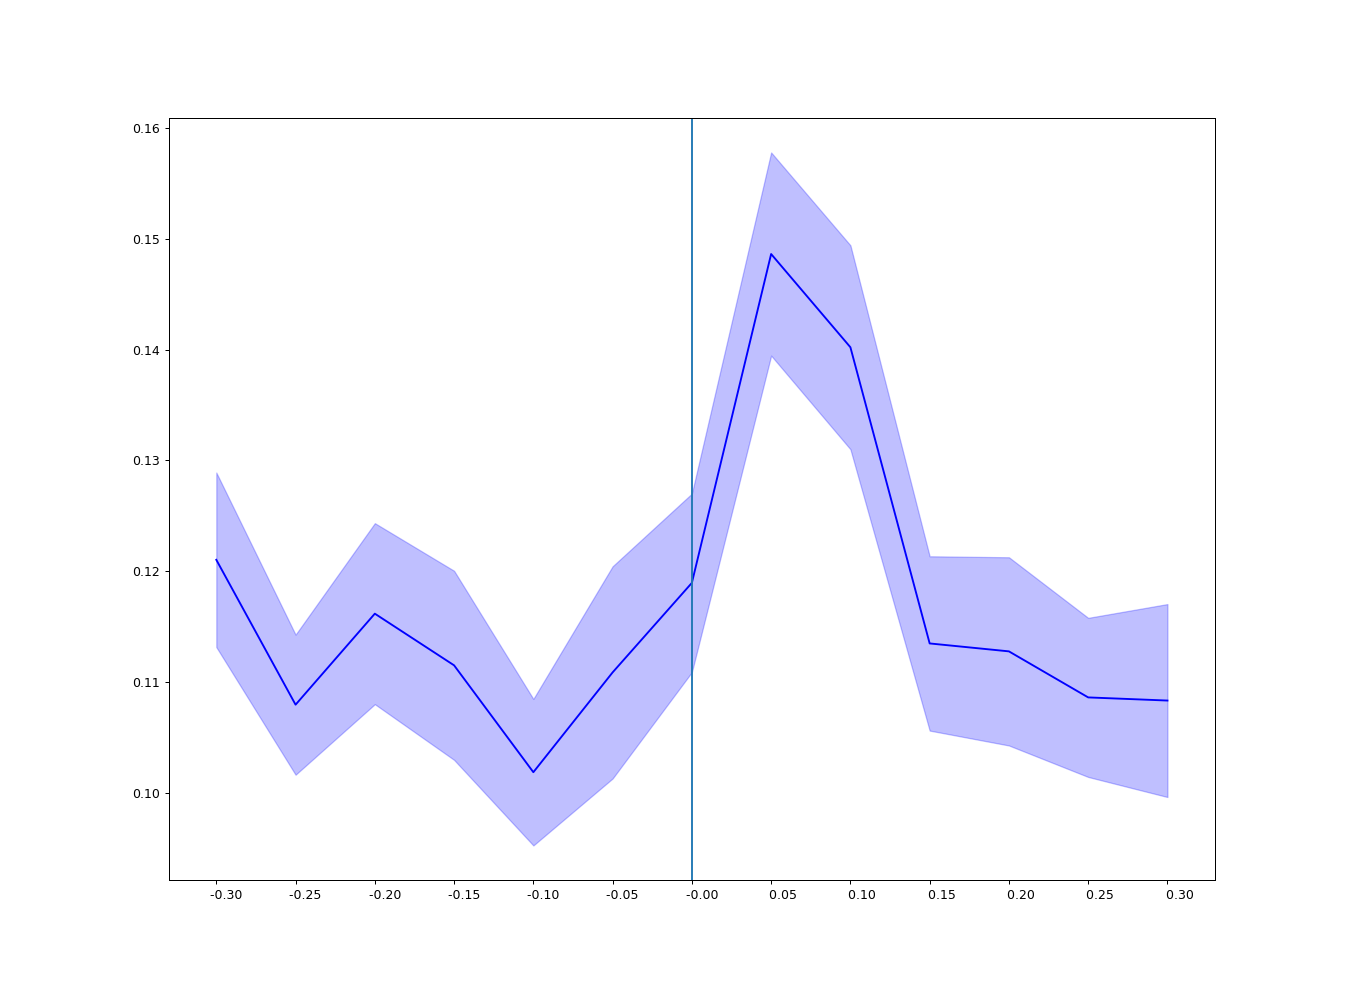

In [305]:
prob_mat = np.array([s for s in prob_vect_all_for_file_ton.values()])



prob_mat_mean = np.mean(prob_mat, axis = 0)
prob_mat_se = np.std(prob_mat, axis = 0)/np.sqrt(prob_mat.shape[0])

prob_mat_mean.shape

fig = plt.figure(figsize=(15,11))
from scipy.signal import savgol_filter
# smoothed_mean = savgol_filter(prob_mat_mean,5,2)
smoothed_mean = prob_mat_mean[4:-3]
smoothed_sd = prob_mat_se[4:-3]

x = np.arange(np.round(iss_son_time, 3) + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1], cs_prob_bin_size)
x = x[4:-3]
xlab = ['{:10.2f}'.format(xl) for xl in np.arange(cs_prob_range[0],cs_prob_range[1],cs_prob_bin_size)]
xlab = xlab[4:-3]
ax = plt.plot(x, smoothed_mean, 'b')[0]

plt.fill_between(x, smoothed_mean - smoothed_sd, smoothed_mean + smoothed_sd, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,xlab)
plt.axvline([x[int(x.size/2)]])
from matplotlib.ticker import FormatStrFormatter
# ax.axes.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


<IPython.core.display.Javascript object>


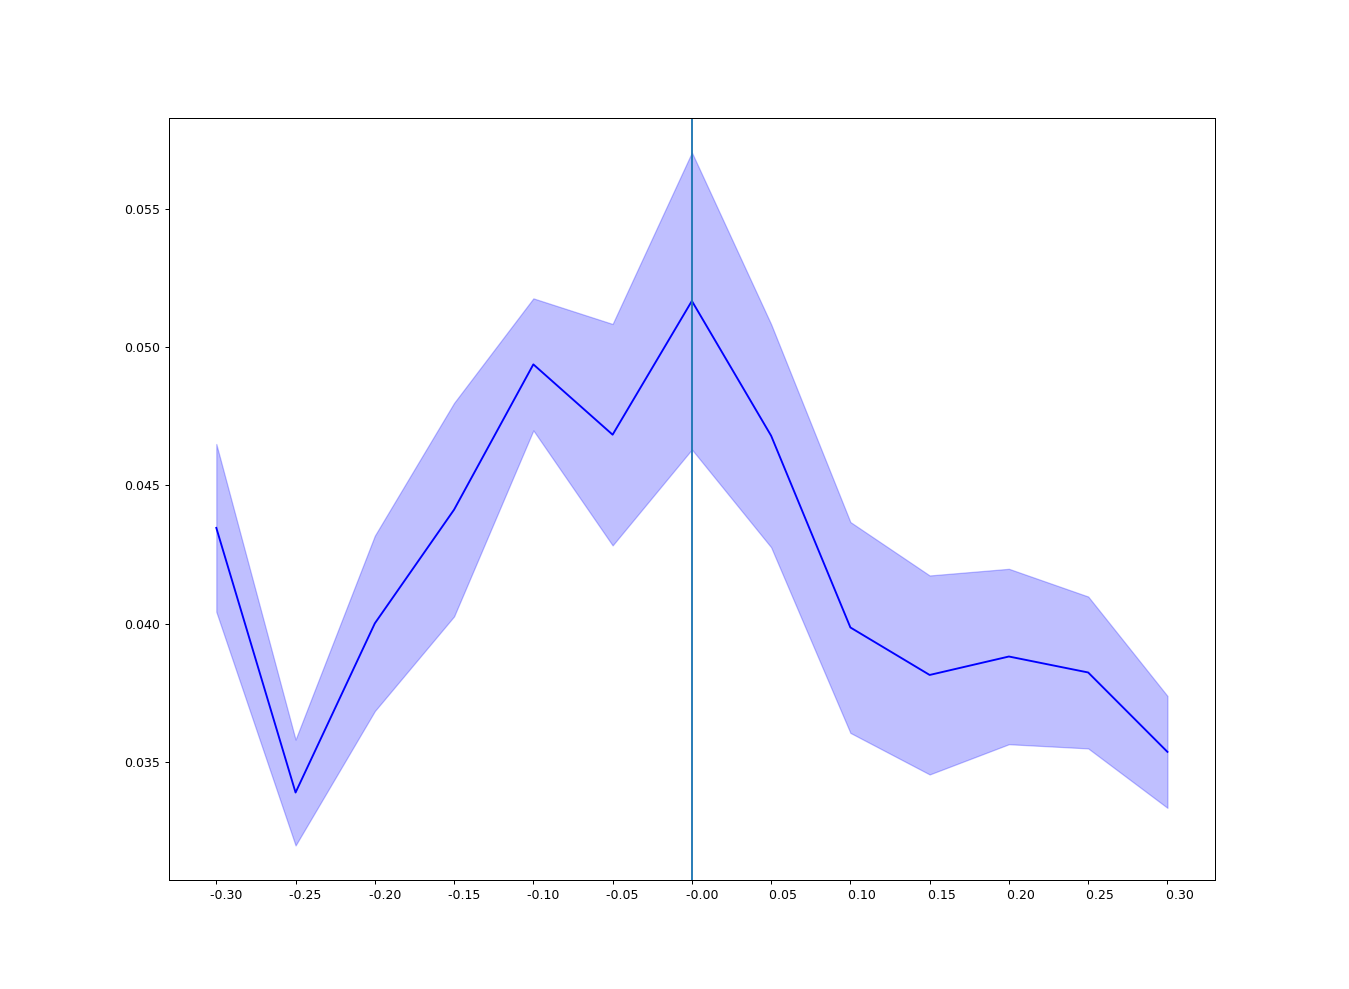

In [306]:
prob_mat = np.array([s for s in prob_vect_all_for_file_son.values()])



prob_mat_mean = np.mean(prob_mat, axis = 0)
prob_mat_se = np.std(prob_mat, axis = 0)/np.sqrt(prob_mat.shape[0])

prob_mat_mean.shape

fig = plt.figure(figsize=(15,11))
from scipy.signal import savgol_filter
# smoothed_mean = savgol_filter(prob_mat_mean,5,2)
smoothed_mean = prob_mat_mean[4:-3]
smoothed_sd = prob_mat_se[4:-3]

x = np.arange(np.round(iss_son_time, 3) + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1], cs_prob_bin_size)
x = x[4:-3]
xlab = ['{:10.2f}'.format(xl) for xl in np.arange(cs_prob_range[0],cs_prob_range[1],cs_prob_bin_size)]
xlab = xlab[4:-3]
ax = plt.plot(x, smoothed_mean, 'b')[0]

plt.fill_between(x, smoothed_mean - smoothed_sd, smoothed_mean + smoothed_sd, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,xlab)
plt.axvline([x[int(x.size/2)]])
from matplotlib.ticker import FormatStrFormatter
# ax.axes.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


In [290]:
xlab

['    -0.500',
 '    -0.450',
 '    -0.400',
 '    -0.350',
 '    -0.300',
 '    -0.250',
 '    -0.200',
 '    -0.150',
 '    -0.100',
 '    -0.050',
 '    -0.000',
 '     0.050',
 '     0.100',
 '     0.150',
 '     0.200',
 '     0.250',
 '     0.300',
 '     0.350',
 '     0.400',
 '     0.450']

In [247]:
np.arange(cs_prob_range[0],cs_prob_range[1],cs_prob_bin_size).size

20

In [231]:
x[int(x.size/2)]

1463.8629999999996

In [213]:
prob_mat = np.array([s for s in prob_vect_all_for_file_soff.values()])



prob_mat_mean = np.mean(prob_mat, axis = 0)
prob_mat_se = np.std(prob_mat, axis = 0)/np.sqrt(prob_mat.shape[0])

prob_mat_mean.shape

# plt.figure(figsize=(8,7))
from scipy.signal import savgol_filter
smoothed_mean = savgol_filter(prob_mat_mean,5,2)

l = plt.plot(np.arange(np.round(iss_son_time, 3) + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1], cs_prob_bin_size), smoothed_mean, 'b')
plt.fill_between(np.arange(np.round(iss_son_time, 3) + cs_prob_range[0] , np.round(iss_son_time, 3) + cs_prob_range[1], cs_prob_bin_size), smoothed_mean - prob_mat_se, smoothed_mean + prob_mat_se, color=l[0].get_color(), alpha=0.25)

In [46]:
a = [1,2,3,3.1,4.1,5]
np.digitize(a, bins = [0, 2.5, 4])[0:-1]

array([1, 1, 2, 2, 3])

In [ ]:
    cs_prob_bin_size = 0.010
    cs_prob_range = [-0.300, 0.300]
    prob_vect_all = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))
    for iss_son_time in mysess.saccade_onset_times[iss_saccades]:
        
        prob_vect = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))
        prob_vect[np.digitize(cs_t, bins = np.arange(st + cs_prob_range[0] , st + cs_prob_range[1], cs_prob_bin_size))] = 1
        prob_vect_all = prob_vect_all + prob_vect



In [41]:
st = 5.162691601562477
cs_t = [4.8891, 5.00273333, 5.29663333]

array([  0.,   0.,   0., 572.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 572.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       572.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [37]:
cs_prob_bin_size = 0.010
cs_prob_range = [-0.300, 0.300]
prob_vect = np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))
prob_vect[np.digitize(cs_t, bins = np.arange(st + cs_prob_range[0] , st + cs_prob_range[1], cs_prob_bin_size))] = 1


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 234.])

In [26]:
np.arange(st - 0.300 , st + 0.300, 0.010).shape

(60,)

In [51]:
np.zeros(np.int(np.diff(cs_prob_range)/cs_prob_bin_size))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
from scipy.io import loadmat
# saving mysess
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

    
bin_cs_counts_for_file = {}
bin_cs_counts_iss_for_file = {}
bin_cs_counts_non_iss_for_file = {}
bin_cs_counts_non_iss_target_jumps_for_file = {}
bin_cs_counts_iss_target_jumps_for_file = {}


for i,fn in enumerate(fnames_behavioral):
    print(fn)
    input_fn_mat = fn + '.session.mat'
    input_fn_session = fn + '.session.pkl'
    data = loadmat(input_fn_mat)
    with open(input_fn_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)
    
#     (rt, rt_toffs, rt_toff_indices) = calc_saccade_reaction_time_to_target_offset(mysess, np.squeeze(data['non_iss_target_jumps_with_following_iss_tj']))
    
    with open(fnames_cs_indices[i], 'r') as csv_f:
        reader = csv.reader(csv_f)
        cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))

    iss_range = 0.025
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []

    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    #     iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
    #                                                              mysess.target_onset_times > son - iss_range), 
    #                                               np.logical_and(mysess.target_offset_times < soff + iss_range, 
    #                                                              mysess.target_offset_times > soff - iss_range)))[0])
        iss_targets.append(np.where(np.logical_and(mysess.target_onset_times > son - iss_range , mysess.target_offset_times < soff + iss_range))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), iss_targets)


    mysess._calc_error_vectors()

    error_dir_bin_ind = mysess.bin_error_dirs()
#     error_mag_bin_ind = mysess.bin_error_mags()
    
    error_dir_bin_ind = bin_error_dirs(mysess.error_dir)
    
    iss_saccades = np.array(iss_saccades)

    iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[iss_saccades])
    non_iss_saccades_bin_ind = bin_error_dirs(mysess.error_dir[saccades_with_no_iss_target])

    error_dir_bin_numbers = np.unique(error_dir_bin_ind)
#     error_mag_bin_numbers = np.unique(error_mag_bin_ind)
    ################## for target jumps
    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))
    non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0
    ##################################
    
    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[iss_targets]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[iss_targets]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[iss_targets]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[iss_targets]])

    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))
    iss_target_jump_bin_ind[iss_target_jump_bin_ind == 8] = 0
    
    
#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180, 180, 45))
#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0

#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180, 180, 60))
#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 6] = 0
    
#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180, 180, 45))
#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 8] = 0


#     non_iss_target_jump_bin_ind = np.digitize(target_jump_dir, bins = [-135, -45, 45, 135])

#     non_iss_target_jump_bin_ind[non_iss_target_jump_bin_ind == 4] = 0
#     iss_targets_for_file[ff] = get_bin_cs_counts(0.160, mysess.target_offset_times[non_iss_target_jumps],
#                                                 bin_ind, np.unique(bin_ind), cs_times_gmm)

    
    bin_cs_counts_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times, error_dir_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
    bin_cs_counts_iss_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[iss_saccades], iss_saccades_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
    bin_cs_counts_non_iss_for_file[fn] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[saccades_with_no_iss_target], non_iss_saccades_bin_ind, error_dir_bin_numbers, cs_indices/30000.0)[1]
    bin_cs_counts_non_iss_target_jumps_for_file[fn] = get_bin_cs_counts(0.200, mysess.target_onset_times[non_iss_target_jumps], non_iss_target_jump_bin_ind, np.unique(non_iss_target_jump_bin_ind), cs_indices/30000.0)[1]
    bin_cs_counts_iss_target_jumps_for_file[fn] = get_bin_cs_counts(0.200, mysess.target_onset_times[iss_targets], iss_target_jump_bin_ind, np.unique(iss_target_jump_bin_ind), cs_indices/30000.0)[1]
    


../data/behavioral/2019_08_12/random_corrective_saccades_153356.fhd
../data/behavioral/2019_08_12/random_corrective_saccades_160452.fhd
../data/behavioral/2019_04_12/random_corrective_saccades_120703.fhd
../data/behavioral/2019_04_12/random_corrective_saccades_122026.fhd
../data/behavioral/2019_04_15/random_corrective_saccades_153820.fhd
../data/behavioral/2019_04_24/random_corrective_saccades_160409.fhd
../data/behavioral/2019_04_24/random_corrective_saccades_153400.fhd
../data/behavioral/2019_04_26/random_corrective_saccades_131916.fhd
../data/behavioral/2019_05_01/random_corrective_saccades_141618.fhd
../data/behavioral/2019_05_15/random_corrective_saccades_135236.fhd
../data/behavioral/2019_05_16/random_corrective_saccades_144904.fhd
../data/behavioral/2019_07_24/random_corrective_saccades_141028.fhd
../data/behavioral/2019_07_24/random_corrective_saccades_142944.fhd
../data/behavioral/2019_04_03/random_corrective_saccades_141321.fhd


In [20]:
bin_cs_counts_iss_target_jumps_for_file.values()

dict_values([array([0.30612245, 0.18367347, 0.18571429, 0.24545455, 0.12765957,
       0.15      , 0.26190476, 0.4137931 ]), array([0.28888889, 0.21276596, 0.14285714, 0.13207547, 0.14705882,
       0.08108108, 0.30263158, 0.4       ]), array([0.36363636, 0.2745098 , 0.18181818, 0.        , 0.1125    ,
       0.        ]), array([0.23529412, 0.        , 0.21794872, 0.08928571, 0.        ,
       0.05769231, 0.        ]), array([0.2195122 , 0.        , 0.17293233, 0.        , 0.19727891,
       0.        , 0.12195122, 1.        ]), array([0.17171717, 0.15454545, 0.5       , 0.09090909, 0.        ,
       0.09322034]), array([0.19653179, 0.        , 0.17791411, 0.        , 0.05755396,
       0.5       , 0.08      , 0.        ]), array([0.21568627, 0.16666667, 0.15068493, 0.        , 0.21538462]), array([0.14285714, 0.5       , 0.12359551, 0.        , 0.22340426,
       0.        , 0.15841584]), array([0.20895522, 0.        , 0.20754717, 0.        , 0.12962963,
       0.        , 0.235294

In [28]:
# tunings_all = []
# for val in bin_cs_counts_for_file.values():
#     print(val)
#     print(np.argmax(val))
#     zero_idx = np.argmax(val)
#     tunings_all.append(np.roll(val, 3-zero_idx , axis=0))
    
# tunings_iss = []
# for val in bin_cs_counts_iss_for_file.values():
#     print(val)
#     print(np.argmax(val))
#     zero_idx = np.argmax(val)
#     tunings_iss.append(np.roll(val, 3-zero_idx , axis=0))
    
# tunings_non_iss = []
# for val in bin_cs_counts_non_iss_for_file.values():
#     print(val)
#     print(np.argmax(val))
#     zero_idx = np.argmax(val)
#     tunings_non_iss.append(np.roll(val, 3-zero_idx , axis=0))
# #     stim_tunings.append(np.roll(csv_content, 3-zero_idx , axis=1)[3,:])

# tunings_target_jump_non_iss = []
# for val in bin_cs_counts_non_iss_target_jumps_for_file.values():
#     print(val)
#     print(np.argmax(val))
#     zero_idx = np.argmax(val)
#     tunings_target_jump_non_iss.append(np.roll(val, 3-zero_idx , axis=0))

tunings_target_jump_iss = []
for val in bin_cs_counts_iss_target_jumps_for_file.values():
    print(val)
    print(np.argmax(val))
    zero_idx = np.argmax(val)
    tunings_target_jump_iss.append(np.roll(val, 3-zero_idx , axis=0))



[0.30612245 0.18367347 0.18571429 0.24545455 0.12765957 0.15
 0.26190476 0.4137931 ]
7
[0.28888889 0.21276596 0.14285714 0.13207547 0.14705882 0.08108108
 0.30263158 0.4       ]
7
[0.36363636 0.2745098  0.18181818 0.         0.1125     0.        ]
0
[0.23529412 0.         0.21794872 0.08928571 0.         0.05769231
 0.        ]
0
[0.2195122  0.         0.17293233 0.         0.19727891 0.
 0.12195122 1.        ]
7
[0.17171717 0.15454545 0.5        0.09090909 0.         0.09322034]
2
[0.19653179 0.         0.17791411 0.         0.05755396 0.5
 0.08       0.        ]
5
[0.21568627 0.16666667 0.15068493 0.         0.21538462]
0
[0.14285714 0.5        0.12359551 0.         0.22340426 0.
 0.15841584]
1
[0.20895522 0.         0.20754717 0.         0.12962963 0.
 0.23529412 0.        ]
6
[0.21568627 0.         0.1375     0.5        0.07228916 0.
 0.07079646 0.        ]
3
[0.09259259 0.06451613 0.08571429 0.14814815 0.16216216 0.33333333
 0.26923077 0.08333333]
5
[0.21428571 0.22641509 0.307692

In [26]:
# tunings_all = np.array(tunings_all)
# print(tunings_all.shape)

# tunings_iss = np.array(tunings_iss)
# print(tunings_iss.shape)

# tunings_non_iss = np.array(tunings_non_iss)
# print(tunings_non_iss.shape)

tunings_target_jump_non_iss = np.array(tunings_target_jump_non_iss)
print(tunings_target_jump_non_iss.shape)

tunings_target_jump_iss = np.array(tunings_target_jump_iss)
print(tunings_target_jump_iss.shape)

(14, 8)
(14,)


In [13]:

# mean_all_saccades = np.mean(tunings_all, axis = 0)
# sd_all_saccades = np.std(tunings_all, axis = 0)/np.sqrt(tunings_all.shape[0]-1)

mean_non_iss = np.mean(tunings_non_iss, axis = 0)
sd_non_iss = np.std(tunings_non_iss, axis = 0)/np.sqrt(tunings_non_iss.shape[0]-1)

mean_iss = np.mean(tunings_iss, axis = 0)
sd_iss = np.std(tunings_iss, axis = 0)/np.sqrt(tunings_iss.shape[0]-1)

# mean_target_non_iss = np.mean(tunings_target_jump_non_iss, axis = 0)
# sd_target_non_iss = np.std(tunings_target_jump_non_iss, axis = 0)/np.sqrt(tunings_target_jump_non_iss.shape[0]-1)

<IPython.core.display.Javascript object>


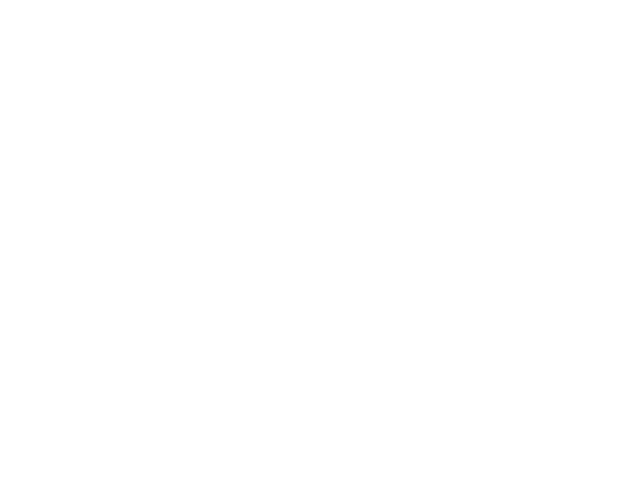

NameError: name 'x' is not defined

In [21]:
plt.figure()
l = plt.plot(x, mean_all_saccades, 'b')
plt.fill_between(x, mean_all_saccades - sd_all_saccades, mean_all_saccades + sd_all_saccades, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)


In [147]:
for val in bin_cs_counts_for_file.values():
    print(bins[np.argmax(val)] - bins[np.argmin(val)])

270.0
-135.0
-225.0
-135.0
-225.0
-180.0
-180.0
45.0
225.0
225.0
-180.0
180.0
90.0
180.0


In [29]:
np.arange(mean_iss.size)

array([0, 1, 2, 3, 4, 5])

<IPython.core.display.Javascript object>


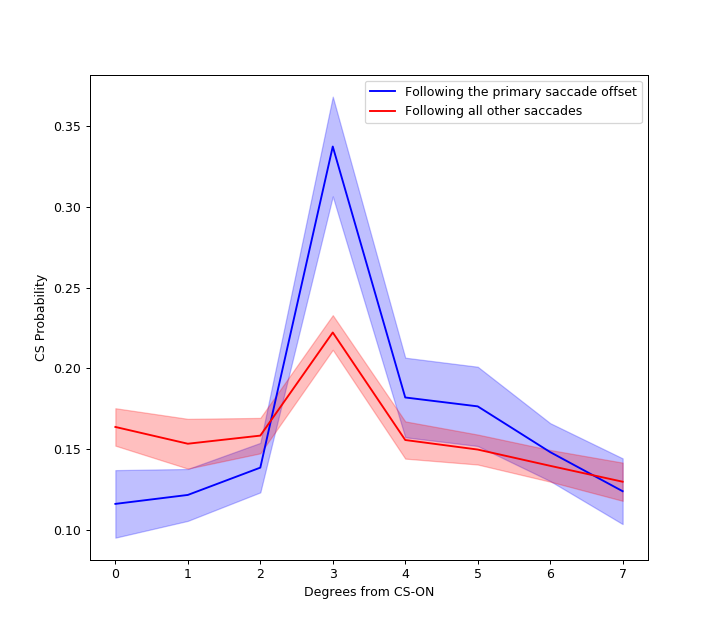

In [14]:

# x = [-180, -90, 0, 90]
plt.figure(figsize=(8,7))


l = plt.plot(mean_iss, 'b')
plt.fill_between(np.arange(mean_iss.size), mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(mean_non_iss, 'r')
plt.fill_between(np.arange(mean_iss.size), mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

# l = plt.plot(x, mean_target_non_iss, 'k')
# plt.fill_between(x, mean_target_non_iss - sd_target_non_iss, mean_target_non_iss + sd_target_non_iss, color=l[0].get_color(), alpha=0.25)

# plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['Following the primary saccade offset', 'Following all other saccades'])

In [25]:
theta = np.array([-135, -90, -45, 0, 45, 90, 135, 180, -135])*np.pi/180

In [16]:
theta = np.array([-135, -90, -45, 0, 45, 90, 135, 180])*np.pi/180


In [25]:
theta = np.arange(-180, 180, 60)*np.pi/180

<IPython.core.display.Javascript object>


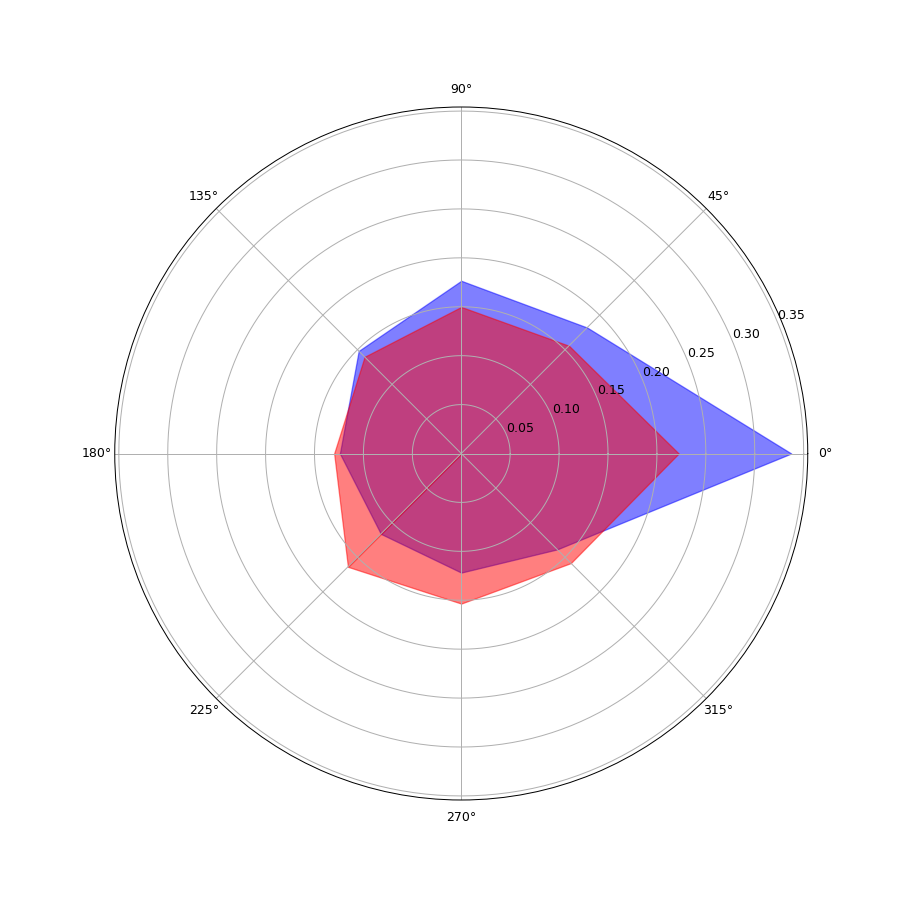

In [19]:
plt.figure(figsize=(10,10))
plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_iss , mean_iss[0])), alpha = 0.02,color = 'b' )
plt.fill_between( np.hstack((theta, theta[0])),0, np.hstack((mean_iss , mean_iss[0])), alpha = 0.5, color = 'b')

plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_non_iss , mean_non_iss[0])), alpha = 0.02,color = 'r' )
plt.fill_between(np.hstack((theta, theta[0])),0, np.hstack((mean_non_iss , mean_non_iss[0])), alpha = 0.5, color = 'r')

In [20]:
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_polar.png')
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_with_polar.svg')


<IPython.core.display.Javascript object>


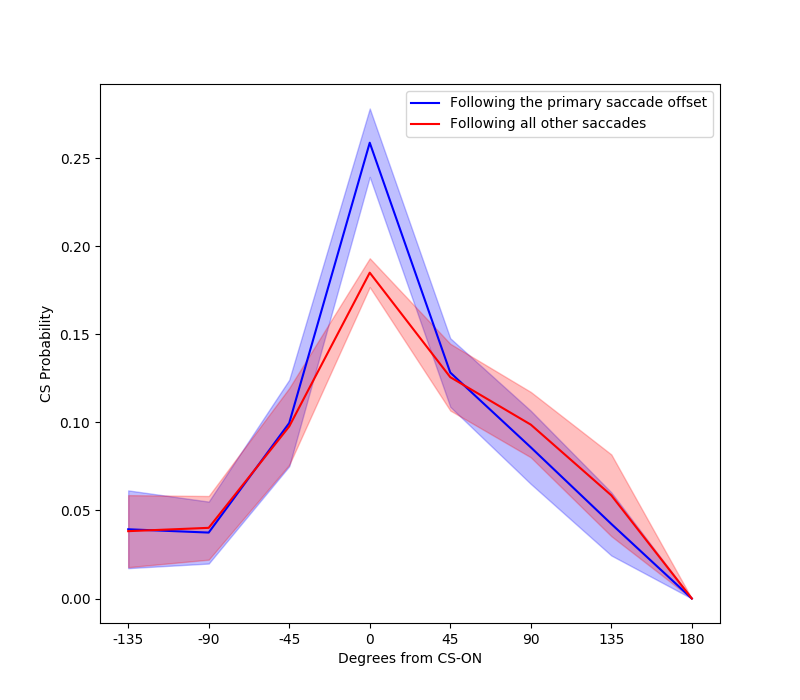

In [40]:
x = [-135, -90, -45, 0, 45, 90, 135, 180]
# x = [-180, -90, 0, 90]
plt.figure(figsize=(8,7))


l = plt.plot(x, mean_iss, 'b')
plt.fill_between(x, mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(x, mean_non_iss, 'r')
plt.fill_between(x, mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

# l = plt.plot(x, mean_target_non_iss, 'k')
# plt.fill_between(x, mean_target_non_iss - sd_target_non_iss, mean_target_non_iss + sd_target_non_iss, color=l[0].get_color(), alpha=0.25)

plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['Following the primary saccade offset', 'Following all other saccades'])

In [130]:
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_with_cue_offset.png')
plt.savefig('../data/plots/Saliency_stuff/marmoset_cs_tuning_with_respect_to_sac_endpoint_with_cue_offset.svg')
